# Анализ данных интернет-магазина товаров для дома и быта 

 Материалы
Презентация:
https://drive.google.com/file/d/1bqDKUMRistM8aOVW0ALu9ioVx4G1dfAW/view?usp=sharing

**Описание проекта**

Интернет-магазину товаров для дома в срочном порядке требуется анализ данных. 

**Задача** — выявление профилей покупателей, а также полноценный анализ товарного ассортимента. 

Полученные профили покупателей будут использоваться отделом маркетинга для рассылки специальных предложений. Для этого, нужно будет определить, в каком сегменте покупатели покупают часто, много и дорого, а на какой сегмент, возможно, не стоит тратить время и деньги, проводя рассылку предложений. Клиентам какого сегмента, когда и из каких категорий товара рассылать предложения и тд. 

**Описание данных**:

- date — дата заказа;
- customer_id — идентификатор покупателя;
- order_id — идентификатор заказа;
- product — наименование товара;
- quantity — количество товара в заказе;
- price — цена товара.

## Загрузка и подготовка данных к анализу

In [1]:
#ячейка с библиотеками
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
from scipy.stats import f_oneway

In [3]:
#выведем полученную таблицу на экран
data

,date,customer_id,order_id,product,quantity,price
0,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0
2,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0
3,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0
4,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0
...,...,...,...,...,...,...
7469,2020013021,63208953-a8e4-4f77-9b47-3a46e7b72eee,104002,томата (помидор) Черниченский черри № 116 сорт...,2,38.0
7470,2020013022,d99d25f1-4017-4fcd-8d29-c580cc695a1a,107336,Дендробиум Санок Анна Грин 1 ствол d-12 см,1,869.0
7471,2020013102,2c9bd08d-8c55-4e7a-9bfb-8c56ba42c6d6,106336,Подставка для обуви резиновая Attribute 80x40 ...,1,354.0
7472,2020013112,cdd17932-623e-415f-a577-3b31312fd0e2,102002,Тагетис крупноцветковый рассада однолетних цве...,1,128.0


In [4]:
#посмотрим информацию о датафрейме
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7474 entries, 0 to 7473
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         7474 non-null   int64  
 1   customer_id  7474 non-null   object 
 2   order_id     7474 non-null   int64  
 3   product      7474 non-null   object 
 4   quantity     7474 non-null   int64  
 5   price        7474 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 350.5+ KB


Этот датафрейм содержит 7474 записей и 6 колонок. Тип данных указан как int64 для колонок date, order_id и quantity, как object -  для колонок customer_id и product, и как float64 для колонки price. Судя по всему, в столбцах отсутствуют пропущенные значения. Но, тип данных столбца date нужно будет привести к формату datetime.

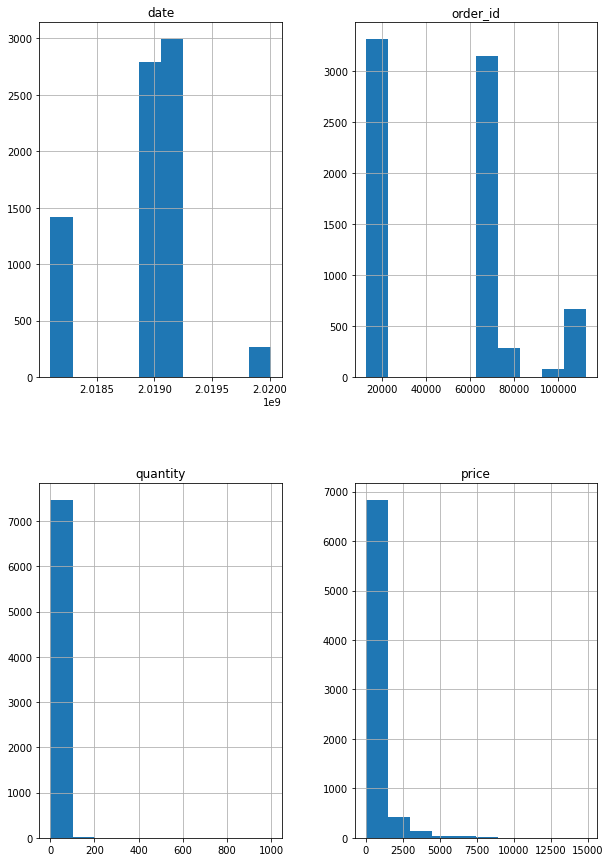

In [5]:
#Построим предварительные гистограммы столбцов
data.hist(figsize=(10, 15));

Согласно графикам, нужно будет проверить на выбросы столбцы price и quantity

## Предобработка данных

### Поиск пропусков

In [6]:
#выведем количество пропущенных значений для каждого столбца
data.isna().sum()

date           0
customer_id    0
order_id       0
product        0
quantity       0
price          0
dtype: int64

Таким образом, подтверждаем, что пропущенных данных в столбцах нет

### Определение явных и неявных дубликатов

In [7]:
#Проверим наличие явных дубликатов
data.duplicated().sum()

0

Явных дубликатов не обнаружено

Далее попробуем выявить неявные дубликаты

In [8]:
# Проверим комбинацию столбцов на уникальность
duplicates = data[data.duplicated(subset=['customer_id', 'order_id', 'product', 'price'], keep=False)]

In [9]:
#отсортируем в порядке возрастания номера заказа и выведем на экран первые 30 строк
duplicates.sort_values(by = 'order_id', ascending = False).head(30)

,date,customer_id,order_id,product,quantity,price
6736,2019103116,344aa778-e436-419e-a9c6-9b8f37b7c1df,73137,Сумка-тележка 2-х колесная Gimi Argo синяя,1,1087.0
6717,2019103009,344aa778-e436-419e-a9c6-9b8f37b7c1df,73137,Сумка-тележка 2-х колесная Gimi Argo синяя,1,1087.0
6729,2019103102,ffaeab76-3a8d-49ee-860f-17273b2fc8a2,73136,"Таз пластмассовый со стиральной доской (Иж), 1...",1,397.0
6728,2019103100,ffaeab76-3a8d-49ee-860f-17273b2fc8a2,73136,"Таз пластмассовый со стиральной доской (Иж), 1...",1,397.0
6716,2019103007,ffaeab76-3a8d-49ee-860f-17273b2fc8a2,73136,"Таз пластмассовый со стиральной доской (Иж), 1...",1,397.0
6711,2019102821,cb65d08a-dae7-4890-aef0-bb9f79055e02,73108,Мирт d-9 см h-15 см,1,134.0
6704,2019102808,cb65d08a-dae7-4890-aef0-bb9f79055e02,73108,Мирт d-9 см h-15 см,1,134.0
6699,2019102715,b89ace7f-7017-408c-8755-c4ff39b50980,73104,Циперус Зумула d-12 см h-25 см,2,112.0
6703,2019102806,b89ace7f-7017-408c-8755-c4ff39b50980,73104,Циперус Зумула d-12 см h-25 см,2,112.0
6700,2019102716,b89ace7f-7017-408c-8755-c4ff39b50980,73104,Циперус Зумула d-12 см h-25 см,2,112.0


In [10]:
#Посмотрим, сколько всего таких дубликатов
data[data.duplicated(subset=['customer_id', 'order_id', 'product', 'price'],
                           keep=False)].shape

(2390, 6)

Как видим, достаточно много строк, где информация дублируется. Полученные дубликаты могут быть связаны с тем, что одни и те же товары добавлены в один заказ несколько раз. Это может произойти по различным причинам, например, из-за ошибки в системе заказов или повторного добавления товара в корзину перед оформлением заказа. Если мы хотим анализировать общий объем продаж и средний чек, наличие дубликатов может привести к искажению данных. В этом случае удаление дубликатов может быть целесообразным. Поэтому мы удаляем дубликаты, оставляя первое упоминание.

In [11]:
#посчитаем сколько процентов данных от исходных данных у нас осталось после удаления дубликатов
data.drop_duplicates(subset=['customer_id', 'order_id', 'product', 'price']).shape[0]/data.shape[0]*100

74.79261439657479

В результате удаления дубликатов мы лишились ок 26% исходной информации

In [12]:
data = data.drop_duplicates(subset=['customer_id', 'order_id', 'product', 'price'])

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5590 entries, 0 to 7473
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         5590 non-null   int64  
 1   customer_id  5590 non-null   object 
 2   order_id     5590 non-null   int64  
 3   product      5590 non-null   object 
 4   quantity     5590 non-null   int64  
 5   price        5590 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 305.7+ KB


Теперь наш датафрейм содержит 5590 записей и 6 колонок.

### Изменение типа данных

Согласно предварительному анализу данных, в колонке date у нас данные о дате представлены в формате int64. Для дальнейшей работы с датой нужно преобразовать данный столбец в тип datetime

In [14]:
#посмотрим на полученную таблицу
data.tail(20)

,date,customer_id,order_id,product,quantity,price
7454,2020012811,ea0d1348-249e-4aff-9149-599eb6d98dec,106547,Настурция Орхидное пламя 5 шт 4650091480692,1,14.0
7455,2020012811,eeba9850-8d4b-40a7-a110-6d11a9196ddc,103325,Кружка для чая Сердечки 250 мл ДСГ55029146,1,45.0
7456,2020012814,57c8999f-ebad-485c-985e-9dc99837775d,112325,Рассада Капусты белокачанная сорт Сибирячка ка...,2,120.0
7457,2020012815,92b18c53-a3d3-44cf-9492-a3566017d611,106880,Форма для выпечки ALPENKOK AK-6038S для кекса ...,1,254.0
7458,2020012815,04d4b824-7b31-4262-8aa0-e43772602521,110214,Тарелка обеденная КОТОН ФЛАУЭР 25 см H2776 Lum...,1,90.0
7459,2020012818,75c1d45a-be89-4f94-8c38-0d386f718943,102547,Вешалка-сушилка Gimi Paco,1,1087.0
7460,2020012821,709dabff-4d9a-4ab0-9e1c-39c253bf90ad,105880,"Сумка-тележка хозяйственная Rolser Paris, борд...",1,4117.0
7461,2020012823,c420236c-ebad-4027-a27d-a3e92fbfe11d,109214,Цинерания рассада однолетних цветов в кассете ...,1,210.0
7462,2020012911,9777b839-4212-41bb-94c2-87de3658248a,111436,"Крючок проволочный 120 мм оцинкованный, 1110212",1,15.0
7463,2020012912,331e6879-1974-48fb-b8c4-65f03edbb64d,112547,Коврик интерьерный для кухни Tuscan Wine из ПВ...,1,1012.0


In [15]:
# преобразуем данные о времени
data = data.copy()
data['date'] = pd.to_datetime(data['date'], format='%Y%m%d%H')

In [16]:
#посмотрим на полученную таблицу
data.tail(20)

,date,customer_id,order_id,product,quantity,price
7454,2020-01-28 11:00:00,ea0d1348-249e-4aff-9149-599eb6d98dec,106547,Настурция Орхидное пламя 5 шт 4650091480692,1,14.0
7455,2020-01-28 11:00:00,eeba9850-8d4b-40a7-a110-6d11a9196ddc,103325,Кружка для чая Сердечки 250 мл ДСГ55029146,1,45.0
7456,2020-01-28 14:00:00,57c8999f-ebad-485c-985e-9dc99837775d,112325,Рассада Капусты белокачанная сорт Сибирячка ка...,2,120.0
7457,2020-01-28 15:00:00,92b18c53-a3d3-44cf-9492-a3566017d611,106880,Форма для выпечки ALPENKOK AK-6038S для кекса ...,1,254.0
7458,2020-01-28 15:00:00,04d4b824-7b31-4262-8aa0-e43772602521,110214,Тарелка обеденная КОТОН ФЛАУЭР 25 см H2776 Lum...,1,90.0
7459,2020-01-28 18:00:00,75c1d45a-be89-4f94-8c38-0d386f718943,102547,Вешалка-сушилка Gimi Paco,1,1087.0
7460,2020-01-28 21:00:00,709dabff-4d9a-4ab0-9e1c-39c253bf90ad,105880,"Сумка-тележка хозяйственная Rolser Paris, борд...",1,4117.0
7461,2020-01-28 23:00:00,c420236c-ebad-4027-a27d-a3e92fbfe11d,109214,Цинерания рассада однолетних цветов в кассете ...,1,210.0
7462,2020-01-29 11:00:00,9777b839-4212-41bb-94c2-87de3658248a,111436,"Крючок проволочный 120 мм оцинкованный, 1110212",1,15.0
7463,2020-01-29 12:00:00,331e6879-1974-48fb-b8c4-65f03edbb64d,112547,Коврик интерьерный для кухни Tuscan Wine из ПВ...,1,1012.0


In [17]:
#проверим
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5590 entries, 0 to 7473
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         5590 non-null   datetime64[ns]
 1   customer_id  5590 non-null   object        
 2   order_id     5590 non-null   int64         
 3   product      5590 non-null   object        
 4   quantity     5590 non-null   int64         
 5   price        5590 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 305.7+ KB


Тип данных был успешно изменен

### Проверка на наличие выбросов в данных

Проверим столбцы price и quantity на наличие выбросов в данных

####  Столбец price

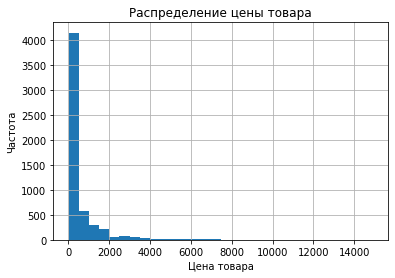

In [18]:
#Построим гистограмму по стоимости товара price с помощью метода hist()
data['price'].hist(bins=30)
plt.xlabel('Цена товара')
plt.ylabel('Частота')
plt.title('Распределение цены товара')
plt.show()

In [19]:
#Посмотрим на товары, стоимостью более 6000 руб
data.query('price>6000')

,date,customer_id,order_id,product,quantity,price
634,2018-11-05 02:00:00,639c4989-b0ab-412a-b7ec-be394cb2d372,68856,Сумка-тележка хозяйственная Rolser IMX005 mare...,1,6007.0
654,2018-11-05 22:00:00,fc333417-1d11-4a2a-b946-0957ae0603e9,68872,Сумка-тележка хозяйственная Rolser MOU041 malv...,1,7597.0
655,2018-11-05 22:00:00,639c4989-b0ab-412a-b7ec-be394cb2d372,68871,Сумка-тележка хозяйственная Rolser IMX005 mare...,1,6007.0
1121,2018-12-06 17:00:00,82b56a76-0dc9-4dae-aa76-863a9a80f082,69236,Покрывало жаккард KARNA стеганое KALVEN 260x26...,1,6134.0
1241,2018-12-17 17:00:00,86c97bf1-c834-423e-9e38-8acda68f97e8,69417,Гладильная доска Leifheit AirBoard Compact M P...,1,7424.0
1420,2018-12-29 09:00:00,ad66d870-22f5-43bc-958f-73420822586b,69681,Сумка-тележка хозяйственная Rolser Pack Gloria...,1,6307.0
1693,2019-02-04 16:00:00,282d20b5-8d00-424f-b339-7adf6c7c16d1,70094,"Сиденье для гладильной доски Leifheit Niveau, ...",1,6149.0
1981,2019-02-24 10:00:00,ac250053-a236-467a-97d2-ddbb9bf4a1ba,70423,Сумка-тележка хозяйственная Andersen Alu Star ...,1,8437.0
2339,2019-03-14 18:00:00,27d4ce42-352b-4756-bf5b-8724e05d5131,70740,Сумка-тележка хозяйственная Rolser IMX006 bass...,1,7679.0
2691,2019-04-05 14:00:00,02adb72a-3067-45e9-a3b5-f93d79d7496a,71030,Сумка-тележка хозяйственная Andersen Scala Sho...,1,6149.0


In [20]:
#Посмотрим на товары, стоимостью более 10000 руб
data.query('price>10000')

,date,customer_id,order_id,product,quantity,price
5992,2019-07-29 17:00:00,0d87f4ae-465a-4fac-81e6-5d629761783e,72139,Сушилка уличная Leifheit 85210 LINOMATIC V 400...,1,14917.0


Судя по всему, дорогие товары представлены сумками- тележками, автоматическими щетками для мытья окон, гладильными досками и стремянками. Было проверено, что данные товары действительно столько стоят и выбросами они не являются

#### Столбец price

Теперь проверим, что у нас с количеством заказанного товара. Нам представлены данные розничного магазина, поэтому закупок по оптовым количествам тут ожидать не стоит.

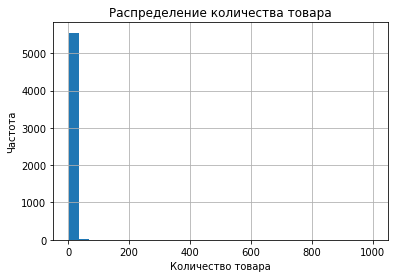

In [21]:
data['quantity'].hist(bins=30)
plt.xlabel('Количество товара')
plt.ylabel('Частота')
plt.title('Распределение количества товара')
plt.show()

In [22]:
#Посмотрим на  заказы, где количество товара превышает 50
data.query('quantity>50')

,date,customer_id,order_id,product,quantity,price
13,2018-10-01 15:00:00,0948b0c2-990b-4a11-b835-69ac4714b21d,68486,Крючок одежный 2-х рожковый серый металлик с п...,96,38.0
160,2018-10-09 09:00:00,c971fb21-d54c-4134-938f-16b62ee86d3b,68580,"Стяжка оконная с болтом СТ-55 цинк, 1108354",64,19.0
211,2018-10-11 14:00:00,cd09ea73-d9ce-48c3-b4c5-018113735e80,68611,"Крепеж для пружины дверной, 1107055",150,19.0
212,2018-10-11 14:00:00,cd09ea73-d9ce-48c3-b4c5-018113735e80,68611,Пружина дверная 240 мм оцинкованная (Д-19 мм) ...,150,38.0
568,2018-11-01 08:00:00,aa42dc38-780f-4b50-9a65-83b6fa64e766,68815,Муляж ЯБЛОКО 9 см красное,170,51.0
586,2018-11-02 11:00:00,0c5aaa88-e346-4f87-8f7a-ad8cbc04e965,68831,Муляж ЯБЛОКО 9 см красное,140,59.0
1023,2018-11-29 17:00:00,8fba3604-ef57-4b9f-b2fe-3402fa8825c8,69156,Набор ножей Attribute CHEF 5 предметов AKF522,64,457.0
1103,2018-12-04 17:00:00,7d255526-fcc2-4f79-b28a-217d7d2373a8,69206,"Щетка для посуды *ОЛЯ*, Мультипласт 1807010",100,26.0
1158,2018-12-10 14:00:00,a984c5b7-ff7e-4647-b84e-ef0b85a2762d,69289,"Ручка-скоба РС-100 белая *Трибатрон*, 1108035",200,29.0
1299,2018-12-21 16:00:00,6987e6d6-a63a-4ce2-a2d0-f424092d235e,69504,Тележка багажная DELTA ТБР-22 синий грузоподъе...,57,574.0


Исходя из предоставленных данных, есть несколько записей, которые могут показаться странными или вызывающими вопросы:
Заказ с 150 пружинами дверными и 150 крепежами для пружин дверных (строки 211 и 212). Такое количество товаров может быть необычным для розничного потребления.
Заказ с 170 муляжами яблока (строка 568) и другой заказ с 300 муляжами яблока (строка 3961). Это выглядит необычным для стандартного потребления, возможно, есть какое-то объяснение, например, оптовая покупка для декораций или специфического мероприятия.
Заказ с 1000 вантузами с деревянной ручкой (строка 5456). Такое количество товаров для розничного покупателя выглядит необычно.
Заказ с 334 мягкими вешалками для деликатных вещей (строка 5071). Это также может быть необычным для стандартного потребления.
Заказ с 1000 кружками с трубочкой (строка 6478). Это также кажется необычным для обычного домашнего использования.

Думаю, что можно удалить заказы с количеством товара более 100 штук

In [23]:
#Посмотрим на  заказы, где количество товара превышает 100
data.query('quantity>100')

,date,customer_id,order_id,product,quantity,price
211,2018-10-11 14:00:00,cd09ea73-d9ce-48c3-b4c5-018113735e80,68611,"Крепеж для пружины дверной, 1107055",150,19.0
212,2018-10-11 14:00:00,cd09ea73-d9ce-48c3-b4c5-018113735e80,68611,Пружина дверная 240 мм оцинкованная (Д-19 мм) ...,150,38.0
568,2018-11-01 08:00:00,aa42dc38-780f-4b50-9a65-83b6fa64e766,68815,Муляж ЯБЛОКО 9 см красное,170,51.0
586,2018-11-02 11:00:00,0c5aaa88-e346-4f87-8f7a-ad8cbc04e965,68831,Муляж ЯБЛОКО 9 см красное,140,59.0
1158,2018-12-10 14:00:00,a984c5b7-ff7e-4647-b84e-ef0b85a2762d,69289,"Ручка-скоба РС-100 белая *Трибатрон*, 1108035",200,29.0
2431,2019-03-23 10:00:00,685d3d84-aebb-485b-8e59-344b3df8b3d3,70841,Плечики пластмассовые Размер 52 - 54 Тула 1205158,150,20.0
3961,2019-05-20 21:00:00,5d189e88-d4d6-4eac-ab43-fa65a3c4d106,71478,Муляж ЯБЛОКО 9 см красное,300,51.0
5071,2019-06-11 07:00:00,146cd9bf-a95c-4afb-915b-5f6684b17444,71668,Вешалки мягкие для деликатных вещей 3 шт шоколад,334,148.0
5456,2019-06-18 15:00:00,312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6,71743,"Вантуз с деревянной ручкой d14 см красный, Bur...",1000,675.0


In [24]:
#Удалим аномалии в столбце quantity
data = data.query('quantity <= 100')

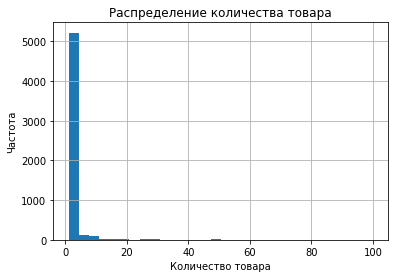

In [25]:
data['quantity'].hist(bins=30)
plt.xlabel('Количество товара')
plt.ylabel('Частота')
plt.title('Распределение количества товара')
plt.show()

## Предварительный анализ данных

### Добавляем новые столбцы

In [26]:
# определяем день недели и месяц заказа
data['weekday'] = data['date'].dt.dayofweek + 1
data['month'] = data['date'].dt.month
data['hour'] = data['date'].dt.hour 
data['year'] = data['date'].dt.year

In [27]:
#посмотрим на полученную таблицу
data.head(10)

,date,customer_id,order_id,product,quantity,price,weekday,month,hour,year
0,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,1,10,0,2018
1,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0,1,10,0,2018
2,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0,1,10,0,2018
3,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0,1,10,0,2018
4,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0,1,10,0,2018
5,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Шеффлера Лузеана d-9 см,1,164.0,1,10,0,2018
6,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Юкка нитчатая d-12 см h-25-35 см,1,134.0,1,10,0,2018
7,2018-10-01 08:00:00,375e0724-f033-4c76-b579-84969cf38ee2,68479,Настенная сушилка для белья Gimi Brio Super 100,1,824.0,1,10,8,2018
8,2018-10-01 08:00:00,6644e5b4-9934-4863-9778-aaa125207701,68478,"Таз пластмассовый 21,0 л круглый ""Водолей"" С61...",1,269.0,1,10,8,2018
9,2018-10-01 09:00:00,c971fb21-d54c-4134-938f-16b62ee86d3b,68480,Чехол для гладильной доски Colombo Persia Beig...,1,674.0,1,10,9,2018


In [28]:
#сделаем новый столбец со стоимостью заказанного товара 
data['cost'] = data['price']* data['quantity']

In [29]:
#посмотрим на полученную таблицу
data.head(10)

,date,customer_id,order_id,product,quantity,price,weekday,month,hour,year,cost
0,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,1,10,0,2018,142.0
1,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0,1,10,0,2018,194.0
2,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0,1,10,0,2018,112.0
3,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0,1,10,0,2018,179.0
4,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0,1,10,0,2018,112.0
5,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Шеффлера Лузеана d-9 см,1,164.0,1,10,0,2018,164.0
6,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Юкка нитчатая d-12 см h-25-35 см,1,134.0,1,10,0,2018,134.0
7,2018-10-01 08:00:00,375e0724-f033-4c76-b579-84969cf38ee2,68479,Настенная сушилка для белья Gimi Brio Super 100,1,824.0,1,10,8,2018,824.0
8,2018-10-01 08:00:00,6644e5b4-9934-4863-9778-aaa125207701,68478,"Таз пластмассовый 21,0 л круглый ""Водолей"" С61...",1,269.0,1,10,8,2018,269.0
9,2018-10-01 09:00:00,c971fb21-d54c-4134-938f-16b62ee86d3b,68480,Чехол для гладильной доски Colombo Persia Beig...,1,674.0,1,10,9,2018,674.0


### Категоризация товара

In [30]:
# Преобразуем все слова в столбце 'product' к нижнему регистру
data['product'] = data['product'].str.lower()

In [31]:
#посмотрим на полученную таблицу
data.head(10)

,date,customer_id,order_id,product,quantity,price,weekday,month,hour,year,cost
0,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142.0,1,10,0,2018,142.0
1,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке кофе арабика, d12,...",1,194.0,1,10,0,2018,194.0
2,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,радермахера d-12 см h-20 см,1,112.0,1,10,0,2018,112.0
3,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,хризолидокарпус лутесценс d-9 см,1,179.0,1,10,0,2018,179.0
4,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,циперус зумула d-12 см h-25 см,1,112.0,1,10,0,2018,112.0
5,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,шеффлера лузеана d-9 см,1,164.0,1,10,0,2018,164.0
6,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,юкка нитчатая d-12 см h-25-35 см,1,134.0,1,10,0,2018,134.0
7,2018-10-01 08:00:00,375e0724-f033-4c76-b579-84969cf38ee2,68479,настенная сушилка для белья gimi brio super 100,1,824.0,1,10,8,2018,824.0
8,2018-10-01 08:00:00,6644e5b4-9934-4863-9778-aaa125207701,68478,"таз пластмассовый 21,0 л круглый ""водолей"" с61...",1,269.0,1,10,8,2018,269.0
9,2018-10-01 09:00:00,c971fb21-d54c-4134-938f-16b62ee86d3b,68480,чехол для гладильной доски colombo persia beig...,1,674.0,1,10,9,2018,674.0


Для того, чтобы сегментировать товар по категориям, будем использовать словари. 

In [32]:
# Создадим словарь с категориями и ключевыми словами
categories = {
    'Бытовая техника': [ 'чайник', 'миксер', 'утюг', 'овощеварка', 'фен', 'мантоварка', 'весы', 'мантоварка-пароварка', 'пароварка', 'пылесос','соковарка', 'соковыжималка', 'кипятильник'],
    'Декор и мебель': ['корзина', 'муляж', 'подушка', 'коврик', 'зеркало', 'тумба', 'плед', 'скатерть', 'ковер', 'простыня', 'штора', 'ковров', 'светильник', 'ковёр', 'короб', 'наматрасник', 'наматрицник-чехол', 'коробка', 'комод', 'покрывало', 'постельное', 'кольца', 'мыльница', 'фоторамка', 'этажерка', 'полка', 'полки', 'ключница', 'наматрацник', 'наволочка', 'одеяло', 'обувница', 'пододеяльник', 'стеллаж', 'пуф', 'кофр', 'халат'],
    'Кухонные принадлежности': ['ложка', 'вилка', 'нож', 'сковорода', 'тарелка', 'чашка','крышка', 'мини-сковорода', 'кружек', 'фужеров', 'кувшин', 'кружка', 'толкушка', 'банка', 'противень', 'полотенце', 'салфетка', 'посуды', 'вкладыш', 'термокружка', 'контейнер', 'ножеточка', 'масленка', 'салатник', 'чайный', 'салатников', 'рыбочистка', 'терка', 'лопатка', 'стакан', 'овощечистка', 'измельчитель', 'лоток', 'полотенец', 'стаканов', 'ковш', 'кисточка', 'скребок', 'картофелемялка', 'миска', 'пресс', 'термостакан', 'дуршлаг', 'столовых', 'термос', 'электроштопор', 'блюдце', 'бульонница', 'разделочная', 'просеиватель', 'кастрюля', 'хлебница', 'форма', 'орехоколка', 'скалка', 'емкость СВЧ', 'венчик', 'сито', 'тортница','бокалов', 'форм', 'свч', 'соуса', 'салфетки', 'салфеток', 'блюдо', 'сотейник', 'сахарница', 'половник', 'яйца', 'салфетница', 'салфеток'],
    'Сумки и аксессуары': ['сумка', 'портфель', 'рюкзак', 'косметичка', 'кошелек', 'чемодан', 'портмоне', 'тележка', 'сумка-тележка'],
    'Уборка и хозтовары': ['щетка-сметка', 'сушилка для белья', 'таз', 'ведро', 'швабра', 'мешок для мусора', 'ерш', 'ёрш', 'прищепок', 'прищепки', 'мусорный', 'перчатки', 'биопорошок', 'чистящий', 'щетка', 'щетка-утюжок', 'мыло', 'пена', 'зубная', 'веник', 'швабра', 'ведро', 'насадка', 'совком', 'средство', 'губка', 'антижир', 'ролик', 'ролика', 'бальзам', 'ополаскиватель', 'вантуз', 'кондиционер', 'соль', 'гель', 'совок', 'насадка-отжим', 'сетка', 'дозатор', 'мыло-скраб', 'тряпкодержатель', 'прищепки', 'скребок', 'микрофибры', 'маска', 'отжим', 'шпагат', 'бидон', 'ванна', 'ваза', 'веревка', 'ткань', 'мешок', 'завертка', 'пьезозажигалка', 'пакет', 'ящик', 'корзинка', 'тряпка', 'стяжки', 'сушилка', 'доска гладильная', 'вешалка', 'чехол', 'котел', 'подкладка под чехол', 'вешалок', 'стяжка', 'крючок', 'комплект для ванной', 'плечики', 'подрукавник', 'подголовник для ванной', 'вешалка-плечики', 'сиденье в ванну', 'корыто', 'урна уличная', 'обувная', 'вешалка-стойка', 'держатель для туалетной бумаги', 'пробка для ванны', 'термоментр', 'ящик почтовый', 'рассекатель пламени на газовую плиту', 'сетка для глажения', 'подставка для обуви', 'фал капроновый', 'штанга для ванной', 'бак для белья', 'окномойка', 'урна-пепельница', 'кашпо', 'бензин', 'вешалки', 'термометр', 'подголовник', 'сиденье', 'напильников', 'рукав', 'покрытие', 'подставка', 'решетка вентиляционная',  'уголок оконный', 'пробки', 'гладильная'],
    'Инструменты и аксессуары для ремонта':['крепеж', 'петля', 'пружина', 'стремянки', 'сверел', 'сверло-фреза', 'карниз', 'лестница-стремянка', 'холодная сварка', 'шнур', 'линейка', 'угольник', 'полировки', 'петля-стрела', 'шило', 'ручка-скоба', 'инструмент', 'петля', 'стремянка-табурет', 'штангенциркуль', 'сверло', 'фиксатор-шар', 'стремянка', 'шпингалет'],
     'Цветы и рассада': ['комнатное растение', 'радермахера', 'хризолидокарпус', 'циперус', 'шеффлера', 'юкка','рассада', 'герань', 'пеларгония', 'суккулент', 'эхеверия', 'эвкалипт', 'цветок', 'адиантум', 'роз', 'роза', 'калатея', 'нолина', 'хлорофинтум', 'цикламен', 'глоксиния', 'азалия', 'гортензия', 'хризантема', 'мирт', 'кориандр', 'мирт', 'иссоп', 'сантолина', 'аспарагус', 'афеляндра', 'антуриум', 'молодило', 'фиалка', 'гербера', 'душица', 'мелисса', 'бегония', 'розмарин', 'альбука', 'бальзамин', 'крассула', 'артелизия', 'лаванда', 'мята', 'каланхое', 'примула', 'дендробиум', 'калоцефалус', 'каллуна', 'капсикум', 'соланум', 'бархатцы', 'космея', 'морковь', 'настурция', 'огурец', 'петуния', 'алиссум', 'гвоздика', 'годеция', 'календула', 'капуста', 'кореопсис', 'лапчатка', 'зов', 'флокс', 'эшшольция', 'диффенбахия', 'бальзамин', 'фаленопсис', 'подсолнечник', 'пуансетия', 'гиностемма', 'ель', 'кипарисовик', 'аптения', 'дерево', 'скиммия', 'тимьян', 'алоэ', 'шеффлера', 'спатифиллум', 'эхеверия', 'фикус', 'лиана', 'кодонанта', 'циперус', 'гимнокалициум', 'кофе', 'эхинокактус', 'крокусы', 'гипсофила', 'тюльпаны', 'калибрахоа', 'эпипремнум', 'аквиления', 'горох', 'земляника', 'незабудка', 'седум', 'томат', 'укроп', 'нефролепсис', 'калла', 'декабрист', 'гиацинт', 'вербена', 'чабер', 'бакопа', 'ранункулус', 'газания', 'овсянница', 'георгина', 'смолевка', 'цинния', 'вербейник', 'колокольчик', 'котовник', 'эхинацея', 'ясколка', 'виола', 'папоротник', 'платикодон', 'лилейник', 'энотера', 'пеперомия', 'цитрофортунелла', 'антуриум', 'дыня', 'виноград', 'лобелия', 'томата', 'мускари', 'тагетис', 'цинерария', 'портулак', 'астра', 'арбуз', 'баклажан', 'клубника', 'патиссон', 'джункус', 'хоста', 'гайлардия', 'монарда', 'рудбекия', 'барвинок', 'кампанула', 'хлорофитум', 'артемизия', 'пуансеттия', 'цветов', 'фиттония', 'аквилегия', 'базилик', 'нефролепис', 'тюльпан', 'табак', 'лавр', 'фуксия', 'гардения', 'пиретрум', 'циния', 'вероника', 'драцена', 'фатсия', 'осина', 'травы', 'сцинедапус', 'бузульник', 'солидаго', 'физостегия', 'бадан', 'лен', 'нивянник', 'лантана', 'клена', 'лаватуга', 'анемона', 'буддлея', 'валериана', 'змееголовник', 'любисток', 'петрушка', 'шалфей', 'мимоза', 'кабачок', 'тыква', 'хамедорея', 'зверобой', 'мединилла', 'импатияне', 'клен', 'замиокулькас', 'амариллис', 'рукола', 'пахира', 'литопс', 'муррайя', 'растение', 'сциндапсус', 'импатиенс', 'лаватера']
    }

In [33]:
# Создадим функцию для определения категории товара
def categorize_product(product):
    for category, keywords in categories.items():
        for keyword in keywords:
            if keyword in product:
                return category
    return 'Другое'  # Если ни одно из ключевых слов не найдено, помечаем как "Другое"

# Примененим функцию к столбцу с наименованием товаров
data['category'] = data['product'].apply(categorize_product)

In [34]:
data.head(100)

,date,customer_id,order_id,product,quantity,price,weekday,month,hour,year,cost,category
0,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142.0,1,10,0,2018,142.0,Цветы и рассада
1,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке кофе арабика, d12,...",1,194.0,1,10,0,2018,194.0,Цветы и рассада
2,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,радермахера d-12 см h-20 см,1,112.0,1,10,0,2018,112.0,Цветы и рассада
3,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,хризолидокарпус лутесценс d-9 см,1,179.0,1,10,0,2018,179.0,Цветы и рассада
4,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,циперус зумула d-12 см h-25 см,1,112.0,1,10,0,2018,112.0,Цветы и рассада
...,...,...,...,...,...,...,...,...,...,...,...,...
100,2018-10-04 21:00:00,b02045c7-8d41-463e-8bba-cb172a28125e,68531,плед флисовый 100% полиэстер 185х240 см бежевы...,1,1049.0,4,10,21,2018,1049.0,Декор и мебель
101,2018-10-04 21:00:00,b02045c7-8d41-463e-8bba-cb172a28125e,68531,скатерть династия 100% полиэфир прямоугольная ...,1,1949.0,4,10,21,2018,1949.0,Декор и мебель
102,2018-10-05 00:00:00,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,рассада зелени для кухни лаванды в кассете по ...,1,315.0,5,10,0,2018,315.0,Цветы и рассада
103,2018-10-05 00:00:00,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,рассада зелени для кухни розмарина в кассете п...,1,207.0,5,10,0,2018,207.0,Цветы и рассада


In [35]:
pd.set_option('display.max_rows', None)
data[data['category'] == 'Другое']

,date,customer_id,order_id,product,quantity,price,weekday,month,hour,year,cost,category


### Анализ на какие дни, часы и месяцы приходится пик заказов

Посмотрим насколько полные данные за каждый год

In [36]:
#сначала проанализируем данные за 2018 год
data2018 = data[data['year'] == 2018]

In [37]:
#выведем за какие месяцы представлены данные
data2018['month'].unique()

array([10, 11, 12])

В датасете представлены данные только за конец 2018  года: с октября по декабрь

In [38]:
#проанализируем данные за 2019 год
data2019 = data[data['year'] == 2019]

In [39]:
#выведем за какие месяцы представлены данные
data2019['month'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

За данный год информация предоставлена в полном объеме за все 12 месяцев

In [40]:
#проанализируем данные за 2020 год
data2020 = data[data['year'] == 2020]

In [41]:
#выведем за какие месяцы представлены данные
data2020['month'].unique()

array([1])

За 2020 год в датасете есть информация только за январь

При анализе по месяцам и тд будем брать данные за 2019 год, чтобы не искажать данные

In [42]:
#определим на какие месяцы приходится пик заказов
order_month = data2019.groupby('month')['order_id'].agg('nunique')

In [43]:
order_month

month
1     167
2     289
3     246
4     267
5     182
6     160
7     198
8     174
9     182
10    204
11    217
12    246
Name: order_id, dtype: int64

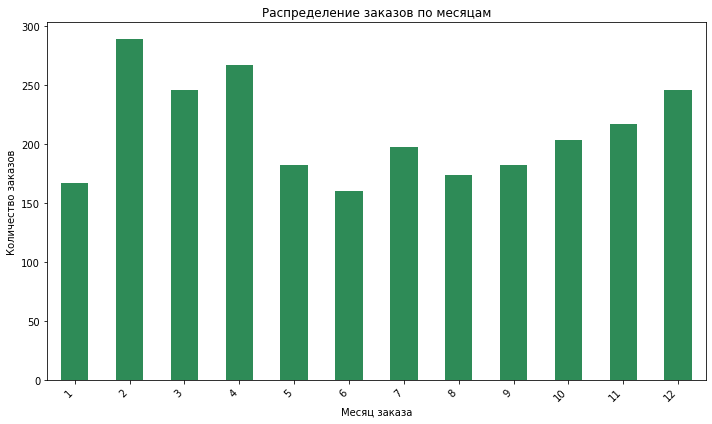

In [44]:
# Построим график
plt.figure(figsize=(10, 6))
order_month.plot(kind='bar', color='seagreen')
plt.title('Распределение заказов по месяцам')
plt.xlabel('Месяц заказа')
plt.ylabel('Количество заказов')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Исходя из распределения заказов по месяцам, можно сделать следующие выводы:
Период с февраля по апрель имеет наибольшее количество заказов (289), что может быть связано с сезонными факторами, маркетинговыми кампаниями или проведением акций.
Июнь (month=6) и январь (month=1) имеют наименьшее количество заказов (160 и 167 соответственно). Это может быть связано с тем, что в эти месяцы покупатели меньше активны из-за начала летнего сезона, когда люди чаще уезжают в отпуск.

In [45]:
#определим на какие часы приходится пик заказов
order_hour = data.groupby('hour')['order_id'].agg('nunique')

In [46]:
order_hour

hour
0      61
1      32
2      23
3      10
4      19
5      23
6      33
7      77
8     149
9     212
10    265
11    291
12    276
13    270
14    257
15    255
16    206
17    189
18    159
19    171
20    151
21    174
22    147
23    107
Name: order_id, dtype: int64

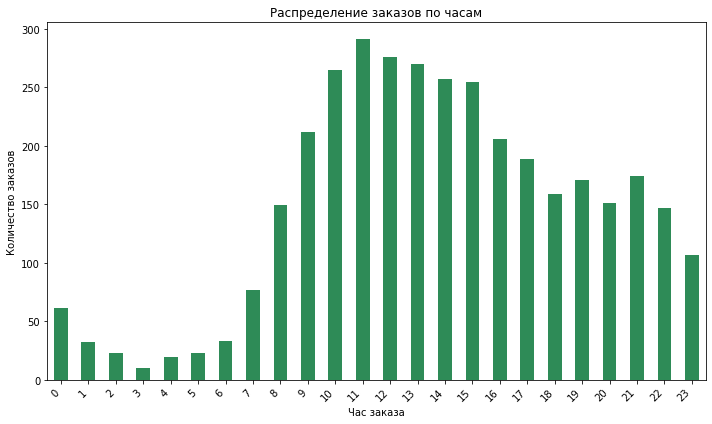

In [47]:
# Построим график
plt.figure(figsize=(10, 6))
order_hour.plot(kind='bar', color='seagreen')
plt.title('Распределение заказов по часам')
plt.xlabel('Час заказа')
plt.ylabel('Количество заказов')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Согласно графику, самое большое количество заказов приходится на период 10-15 часов. Пик заказов приходится на 11 часов утра, где был сделан 291 заказ. Это может указывать на то, что утреннее время является наиболее активным для покупок в данном интернет-магазине. В это время люди, возможно, уже завершили свои утренние дела и находятся в поиске товаров или совершают покупки перед обедом. Также это может быть связано с пиком рабочего дня, когда многие люди имеют перерыв на обед и могут использовать это время для онлайн-шопинга. Наименьшее количество заказов приходится на ночное время. Это типичное время, когда большинство людей спят, поэтому спрос на покупки в этот период времени обычно минимален.

In [48]:
#определим на какие дни недели приходится пик заказов
order_weekday = data.groupby('weekday')['order_id'].agg('nunique')

In [49]:
order_weekday

weekday
1    587
2    602
3    541
4    552
5    461
6    350
7    457
Name: order_id, dtype: int64

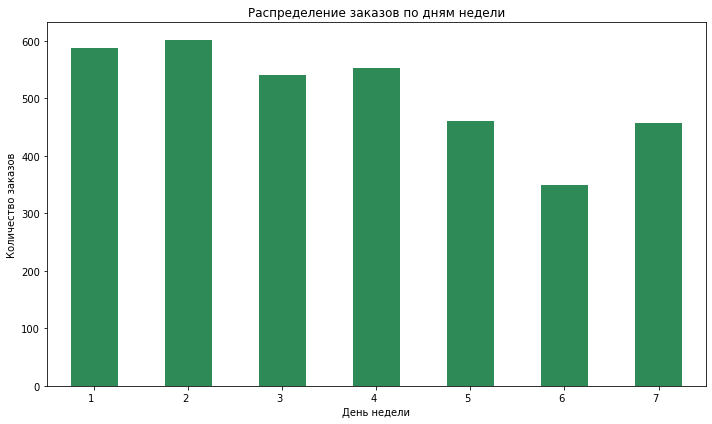

In [50]:
# Построим график
plt.figure(figsize=(10, 6))
order_weekday.plot(kind='bar', color='seagreen')
plt.title('Распределение заказов по дням недели')
plt.xlabel('День недели')
plt.ylabel('Количество заказов')
plt.xticks(rotation=360, ha='right')
plt.tight_layout()
plt.show()

По полученным данным можно сказать следующее о распределении заказов по дням недели:
Вторник (weekday=2) имеет наибольшее количество заказов (602), что может указывать на то, что во вторник покупатели более активны или что компания проводит какие-то акции или мероприятия, стимулирующие покупки в этот день.
Наименьшее количество заказов приходится на субботу (weekday=6) с 350 заказами. Это может быть связано с тем, что в выходные люди могут предпочитать проводить время с семьей или заниматься другими делами, а не делать покупки.

### Анализ категорий товаров

In [51]:
#сгруппируем данные по категориям и посчитаем количество заказов каждой категории
category_count = data.groupby('category')['order_id'].agg('count').sort_values(ascending = False)

In [52]:
category_count

category
Цветы и рассада                         2863
Уборка и хозтовары                      1116
Декор и мебель                           619
Кухонные принадлежности                  457
Сумки и аксессуары                       384
Инструменты и аксессуары для ремонта      82
Бытовая техника                           60
Name: order_id, dtype: int64

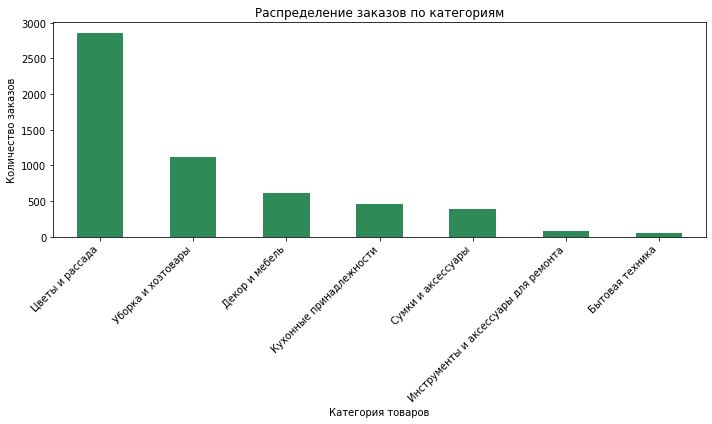

In [53]:
# Построим график
plt.figure(figsize=(10, 6))
category_count.plot(kind='bar', color='seagreen')
plt.title('Распределение заказов по категориям')
plt.xlabel('Категория товаров')
plt.ylabel('Количество заказов')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Результаты анализа категорий товаров позволяют сделать следующие выводы:
Цветы и рассада являются наиболее популярной категорией товаров среди покупателей, с общим числом заказов равным 2863. Это может указывать на высокий спрос на цветочные товары среди клиентов данного магазина.
Уборка и хозтовары также пользуются значительным спросом, что подтверждается количеством заказов - 1116. Это говорит о том, что товары для уборки и бытовой химии также являются важным сегментом ассортимента магазина.
Декор и мебель имеют меньшее количество заказов по сравнению с предыдущими категориями, однако всё еще занимают заметную долю, с общим числом заказов равным 619. Это указывает на интерес покупателей к декоративным и мебельным товарам.
Кухонные принадлежности, Сумки и аксессуары, Инструменты и аксессуары для ремонта, Бытовая техника имеют относительно меньшее количество заказов по сравнению с предыдущими категориями.

In [54]:
#сгруппируем данные по категориям и посчитаем общую сумму выручки для каждой категории
category_cost = data.groupby('category')['cost'].agg('sum').sort_values(ascending= False)

In [55]:
category_cost

category
Уборка и хозтовары                      1.214473e+06
Сумки и аксессуары                      8.358132e+05
Декор и мебель                          6.526532e+05
Цветы и рассада                         6.205910e+05
Кухонные принадлежности                 3.468360e+05
Инструменты и аксессуары для ремонта    1.351850e+05
Бытовая техника                         5.801000e+04
Name: cost, dtype: float64

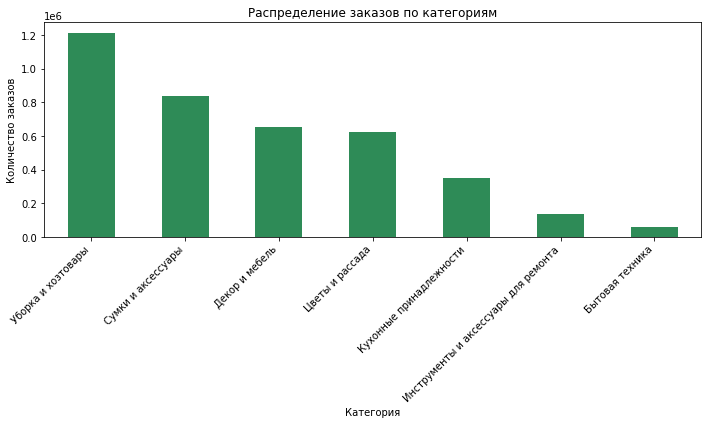

In [56]:
# Построим график
plt.figure(figsize=(10, 6))
category_cost.plot(kind='bar', color='seagreen')
plt.title('Распределение заказов по категориям')
plt.xlabel('Категория')
plt.ylabel('Количество заказов')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Исходя из сгруппированных данных о выручке по категориям товаров, можно сделать следующие выводы:
Цветы и рассада лидируют по выручке среди всех категорий товаров, с общей выручкой в размере 1 289 533. Это может быть связано с высоким спросом на цветы и растения, особенно в периоды праздников, мероприятий и для украшения интерьера.
Сумки и аксессуары занимают второе место по выручке, с общей суммой 792 149 единиц. Поскольку по количеству данная категория находится почти на последнем месте, появление ее в топе по выручке говорит о сравнительно высокой стоимости данных товаров
Уборка и хозтовары также приносят значительную выручку, составляющую 753 742 единицы. Это говорит о постоянном спросе на товары для уборки и хозяйственные товары.
Декор и мебель следующие по величине выручки, составляющей 512 721 единицу. Это может отражать интерес потребителей к декоративным элементам и мебели для дома.
Кухонные принадлежности занимают пятую позицию по выручке с общей суммой 325 747 единиц. Это говорит о постоянном спросе на кухонные аксессуары и принадлежности.
Инструменты и аксессуары для ремонта имеют более низкую выручку по сравнению с другими категориями, составляющую 134 437 единиц. Возможно, это связано с меньшим количеством покупок таких товаров по сравнению с товарами для дома или повседневного использования.
Бытовая техника имеет наименьшую выручку среди всех категорий, составляющую 55 232 единицы. Это может указывать на относительно низкий спрос на бытовую технику по сравнению с другими категориями товаров.

Посмотрим на среднюю стоимость товаров в каждой категории

In [57]:
#сгруппируем данные по категориям и посчитаем среднюю стоимость товара для каждой категории
category_price = data.groupby('category')['price'].agg('mean').sort_values(ascending= False)

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'Сумки и аксессуары'),
  Text(1, 0, 'Инструменты и аксессуары для ремонта'),
  Text(2, 0, 'Бытовая техника'),
  Text(3, 0, 'Уборка и хозтовары'),
  Text(4, 0, 'Декор и мебель'),
  Text(5, 0, 'Кухонные принадлежности'),
  Text(6, 0, 'Цветы и рассада')])

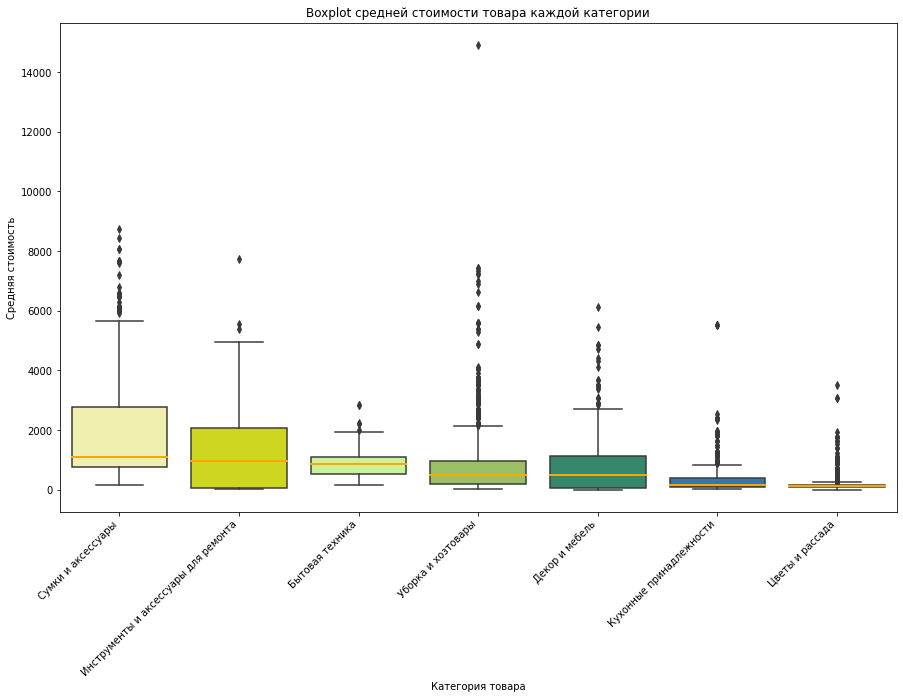

In [58]:
plt.figure(figsize=(15, 9))
custom_palette  = ['#FAFBA4', '#EBF400', "#CFFF8D", "#9BCF53", "#289672", "#2978B5", "#3120E0"]
sns.boxplot(x='category', y='price', data=data, order=category_price.index, 
            palette=custom_palette, medianprops={'color': 'orange', 'linewidth': 2})
plt.title('Boxplot средней стоимости товара каждой категории')
plt.xlabel('Категория товара')
plt.ylabel('Средняя стоимость')
plt.xticks(rotation=45, ha='right')

In [59]:
 data.groupby('category')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
category,,,,,,,,
Бытовая техника,60.0,933.366667,599.607809,164.0,516.50,862.0,1096.250,2849.0
Декор и мебель,619.0,752.042272,872.703807,9.0,59.00,487.0,1139.500,6134.0
Инструменты и аксессуары для ремонта,82.0,1484.621951,1623.130572,15.0,55.75,974.0,2061.500,7724.0
Кухонные принадлежности,457.0,362.477024,592.497529,19.0,89.00,178.0,389.000,5512.0
Сумки и аксессуары,384.0,2045.973307,1781.255007,150.0,749.00,1087.0,2783.375,8737.0
Уборка и хозтовары,1116.0,867.399343,1177.826930,15.0,194.00,487.0,974.000,14917.0
Цветы и рассада,2863.0,141.618058,180.953066,9.0,82.00,120.0,150.000,3524.0


Анализ категорий товаров позволил выявить значительные различия в ценах и стандартном отклонении между разными категориями товаров. В частности, категории "Сумки и аксессуары" , "Инструменты и аксессуары для ремонта" и "Уборка и хозтовары" имеют наибольшую среднюю цену товаров, при этом стандартное отклонение также высоко, что свидетельствует о значительной вариабельности цен внутри каждой категории. Наименьшая средняя цена товаров наблюдается в категории "Цветы и рассада". В целом, эти результаты позволяют лучше понять структуру цен на товары в разных категориях и определить потенциальные стратегии ценообразования и маркетинга для каждой из них.

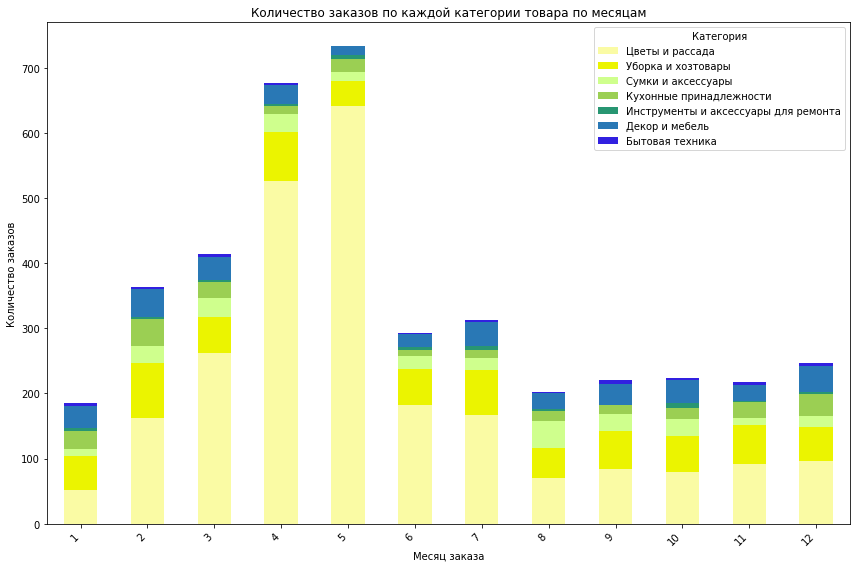

In [60]:
# Сгруппируем данные по месяцам заказа и категориям, затем посчитаем количество заказов
category_month_counts = data2019.groupby(['month', 'category']).size().unstack(fill_value=0)
# Отсортируем столбцы в порядке возрастания
category_month_counts = category_month_counts.sort_index(axis=1, ascending=False)
custom_palette  = ['#FAFBA4', '#EBF400', "#CFFF8D", "#9BCF53", "#289672", "#2978B5", "#3120E0"]
# Построим график
plt.figure(figsize=(12, 8))
# Построим столбчатую диаграмму
category_month_counts.plot(kind='bar', stacked=True, ax=plt.gca(), color=custom_palette)
# Добавим заголовок и подписи осей
plt.title('Количество заказов по каждой категории товара по месяцам')
plt.xlabel('Месяц заказа')
plt.ylabel('Количество заказов')
plt.xticks(rotation=45, ha='right')
# Выведем график на экран
plt.legend(title='Категория')
plt.tight_layout()
plt.show()

Согласно графику, во всех месяцах наибольшую долю составляет категория товаров "цветы и рассада", пик закупок которых приходится на периоды с марта по май. В марте самая горячая пора, когда покупают букеты в подарок, а на апрель и май приходится подготовка к дачному сезону, когда покупатели покупают семена и рассаду. 
Судя по всему, в данном магазине большинство приходят за цветочной продукцией

### Выводы

Анализ данных по распределению заказов по месяцам, дням недели и категориям товаров позволяет сформулировать несколько ключевых выводов. Во-первых, выявлено, что период с февраля по апрель характеризуется наибольшей активностью покупателей, возможно, благодаря сезонным факторам или проведению маркетинговых акций. Наименьшая активность приходится на июнь и январь, вероятно, из-за начала летнего сезона и праздничных периодов соответственно.
Во-вторых, анализ распределения заказов по дням недели выделяет вторник как день с наибольшим количеством заказов, в то время как суббота имеет наименьшее количество заказов. Это может быть связано с покупательскими привычками и распределением времени между работой и отдыхом.
По категориям товаров выявлено, что цветы и рассада являются наиболее популярной категорией среди покупателей, что свидетельствует о высоком спросе на цветочные товары. Сумки и аксессуары, несмотря на меньшее количество заказов, приносят значительную выручку, что может указывать на их высокую стоимость или специализированный спрос. Уборка и хозтовары, а также декор и мебель также имеют заметную долю в выручке, что указывает на их значимость для ассортимента магазина.
Наконец, анализ графика по категориям товаров показывает, что категория "цветы и рассада" доминирует во всех месяцах, особенно с марта по май, что соответствует временам года, когда спрос на цветы и растения обычно высок. Эти выводы могут быть использованы для оптимизации маркетинговых стратегий, ассортимента товаров и управления запасами в интернет-магазине.

## Исследовательский анализ данных

###  Сегментация пользователей на основе RFM –анализа.

Для сегментации пользователей мы будем использовать RFM-анализ.
RFM — это метод, используемый для анализа потребительской ценности.

Он группирует клиентов на основе истории их транзакций:

- Recency (Давность) — Как давно клиент совершил покупку?

- Frequency (Частота) — Как часто они совершают покупки?

- Monetary Value (Денежная ценность) — Сколько они тратят?



Так как датасет не самый свежий, вместо текущей даты будем использовать max+1. Для создания recency, frequency и monetary мы сгруппируем наши записи по customer_id.

In [61]:
last_date = data['date'].max() + timedelta(days=1)
rfm = data.reset_index().groupby('customer_id').agg({'date': lambda x: (last_date - x.max()).days,
                                                 'order_id': lambda x: x.nunique(), 
                                                 'cost': lambda x: x.sum()})
rfm.rename(columns={'date': 'recency', 
                          'order_id': 'frequency', 
                          'cost': 'monetary_value'}, inplace=True)

In [62]:
rfm.reset_index().head(20)

,customer_id,recency,frequency,monetary_value
0,000d6849-084e-4d9f-ac03-37174eaf60c4,108,1,555.0
1,001cee7f-0b29-4716-b202-0042213ab038,350,1,442.0
2,00299f34-5385-4d13-9aea-c80b81658e1b,109,1,914.0
3,002d4d3a-4a59-406b-86ec-c3314357e498,369,1,1649.0
4,003bbd39-0000-41ff-b7f9-2ddaec152037,124,1,2324.0
5,004d24e9-4a6c-4d0e-8727-8391dfd4b43a,370,1,1536.0
6,005ba170-45e8-42de-93f7-192481ae2659,87,2,7857.0
7,00bd74b1-2792-47db-a2f1-680a09ac5026,468,1,937.0
8,00c0f92a-121a-4883-a78d-2c7b5fe187de,51,2,321.0
9,00c95d20-923e-4b45-88fc-53b12931d462,44,2,1145.5


Теперь нам нужно выставить оценки. Мы будем разбивать на диапазон от 1 до 5. Чем шире диапазон, тем более точные наши группы.

Вызовем метод quantile() для датафрейма rfm. Этот метод используется для вычисления квантилей данных в датафрейме. Квантиль - это значение, которое разделяет данные на части определенных долей.

In [63]:
quantiles = rfm[['recency','frequency','monetary_value']].quantile(q=[0.20, 0.40, 0.60, 0.80])
quantiles = quantiles.to_dict()

В данном случае мы передаем параметр q, который представляет собой список значений квантилей, которые мы хотим вычислить. Например, q=[0.20, 0.40, 0.60, 0.80] означает, что мы хотим вычислить квантили, разделяющие данные на пять равных частей, где каждая часть содержит 20% данных. Таким образом, после выполнения этой строки кода, quantiles будет содержать значения квантилей для каждого RFM параметра (recency, frequency, monetary_value) в датафрейме.

In [64]:
# Определение функции для присвоения оценок. Чем меньше значение Recency, тем лучше, для значений Frequency и Monetary наоборот.

def r_score(x):
    if x <= quantiles['recency'][0.20]:
        return 5
    elif x <= quantiles['recency'][0.40]:
        return 4
    elif x <= quantiles['recency'][0.60]: 
        return 3
    elif x <= quantiles['recency'][0.80]:
        return 2
    else:
        return 1
def fm_score(x, c):
    if x <= quantiles[c][0.20]:
        return 1
    elif x <= quantiles[c][0.40]:
        return 2
    elif x <= quantiles[c][0.60]: 
        return 3
    elif x <= quantiles[c][0.80]:
        return 4
    else:
        return 5


Эта функция сравнивает значение x с квантилями в словаре и возвращает оценку от 1 до 5 в зависимости от того, в какой квантиль попадает значение x. Если x меньше или равно 20% квантиля, функция вернет 1. Если x меньше или равно 40% квантиля, но больше 20%, функция вернет 2, и так далее. Если x больше 80% квантиля, функция вернет 5.

In [65]:
# Присвоение оценок
rfm['r'] = rfm['recency'].apply(lambda x: r_score(x))
rfm['f'] = rfm['frequency'].apply(lambda x: fm_score(x, 'frequency'))
rfm['m'] = rfm['monetary_value'].apply(lambda x: fm_score(x, 'monetary_value'))

Расчитаем RFM_score и RFM_segment путем объединения оценок давности (Recency), частоты (Frequency) и стоимости (Monetary) в одно значение.

In [66]:
# Расчет RFM Score и RFM segment
rfm['rfm_segment'] = rfm['r'].map(str) + rfm['f'].map(str) + rfm['m'].map(str)
rfm['rfm_score'] = rfm['r'] + rfm['f'] + rfm['m']

In [67]:
rfm.reset_index().head()

,customer_id,recency,frequency,monetary_value,r,f,m,rfm_segment,rfm_score
0,000d6849-084e-4d9f-ac03-37174eaf60c4,108,1,555.0,4,1,2,412,7
1,001cee7f-0b29-4716-b202-0042213ab038,350,1,442.0,2,1,2,212,5
2,00299f34-5385-4d13-9aea-c80b81658e1b,109,1,914.0,4,1,3,413,8
3,002d4d3a-4a59-406b-86ec-c3314357e498,369,1,1649.0,2,1,4,214,7
4,003bbd39-0000-41ff-b7f9-2ddaec152037,124,1,2324.0,4,1,5,415,10


In [68]:
#посмотрим на уникальные оценки столбца rfm_score
rfm['rfm_score'].unique()

array([ 7,  5,  8, 10, 13, 11,  9,  6, 14,  4, 12,  3])

In [69]:
#Посмотрим на уникальные оценки столбца rfm_segment
rfm['rfm_segment'].unique()

array(['412', '212', '413', '214', '415', '445', '113', '542', '544',
       '541', '314', '315', '312', '355', '213', '545', '115', '211',
       '311', '245', '144', '444', '543', '114', '442', '414', '111',
       '112', '344', '241', '313', '215', '451', '454', '443', '145',
       '411', '345', '242', '142', '244', '342', '341', '441', '143',
       '252', '354', '255', '155', '254', '353', '343', '455', '253',
       '243', '352', '141'], dtype=object)

In [70]:
#посчитаем сколько пользователей в каждой категории по rfm_score
count_rfm_score = rfm.reset_index().groupby('rfm_score')['customer_id'].agg('count')

In [71]:
count_rfm_score

rfm_score
3      86
4     207
5     315
6     354
7     303
8     192
9     137
10    167
11    170
12    186
13    189
14    137
Name: customer_id, dtype: int64

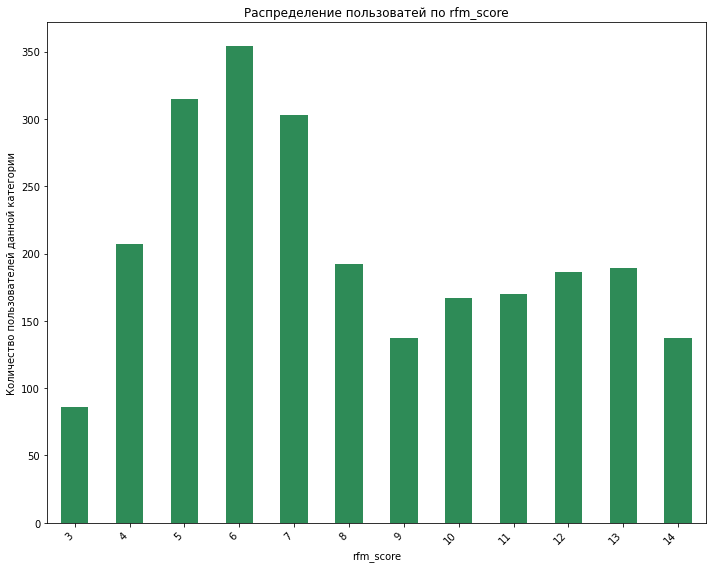

In [72]:
# Построим график
plt.figure(figsize=(10, 8))
count_rfm_score.plot(kind='bar', color='seagreen')
plt.title('Распределение пользоватей по rfm_score')
plt.xlabel('rfm_score')
plt.ylabel('Количество пользователей данной категории')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [73]:
#посчитаем сколько пользователей в каждой категории по rfm_segment
count_rfm_segment =  rfm.reset_index().groupby('rfm_segment')['customer_id'].agg('count').sort_values(ascending=False)

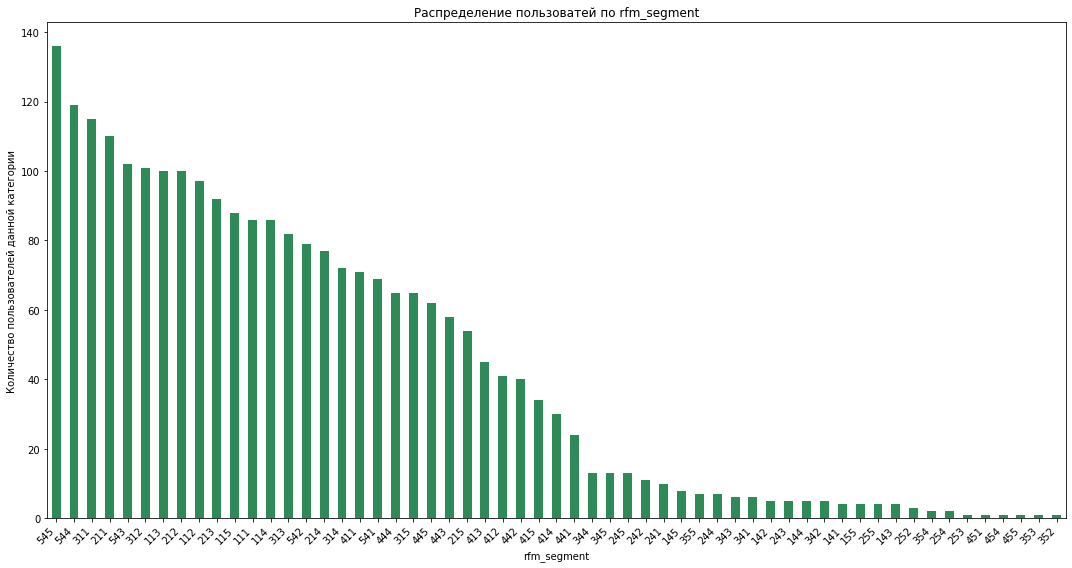

In [74]:
# Построим график
plt.figure(figsize=(15, 8))
count_rfm_segment.plot(kind='bar', color='seagreen')
plt.title('Распределение пользоватей по rfm_segment')
plt.xlabel('rfm_segment')
plt.ylabel('Количество пользователей данной категории')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Хоть проще в дальнейшем будет работать с rfm_score и по ней обозначить наших пользователей, но считаю, что использование rfm_segment даст более точное разделение и больше информации о пользователях.

Результаты rfm_segment дают нам 125 сегментов. С таким количеством сегментов работать неудобно, поэтому выделим несколько. Сделаем разбивку, основанную на оценках r и f.

Для разделения пользователей на более маленькие группы сначала можно рассмотреть комбинации значений r, f и m в rfm_segment и определить их сегментацию на основе этих комбинаций. Затем мы сможем сгруппировать их в соответствии с ожиданиями от каждого сегмента.
Можно разделить их на данные сегменты:

- **Чемпионы**. Купили недавно, покупают часто и тратят больше всего. 
- **Постоянные клиенты**. Покупают на регулярной основе. Отзывчивы к акциям.
- **Потенциальный лоялист**. Последние клиенты со средней частотой.
- **Последние клиенты**. Купили совсем недавно, но делают это не часто. 
- **Перспективные клиенты**. Последние клиенты, но много не потратили.
- **Клиенты, нуждающиеся во внимании**. Выше среднего показатели давности, частоты и денежных затрат. Возможно, давно не совершал покупок. 
- **Засыпающие**. Ниже среднего давность и частота. Потеряем их, если не реактивировать.  
- **В зоне риска**. Покупали часто, но давно. Необходимо вернуть их! 
- **Не можем потерять их**. Покупают часто, но не вернулся в течение длительного времени. 
- **Бездействие**. Последняя покупка была давно и небольшое число заказов. Можем потерять

Попробуем написать функцию: 

In [75]:
def categorize_segment(segment):
    if segment[0] == '5' and segment[1] in ('4', '5'):
        return 'Чемпионы'
    elif segment[0] in ('4', '3') and segment[1] in ('4', '5'):
        return 'Постоянные клиенты'
    elif segment[0] in ('4', '5') and segment[1] in ('2', '3'):
        return 'Потенциальный лоялист'
    elif segment[0] == '5' and segment[1] == '1':
        return 'Последние клиенты'
    elif segment[0] == '4' and segment[1] == '1':
        return 'Перспективные клиенты'
    elif segment[0] == '3' and segment[1] =='3':
        return 'Клиенты, нуждающиеся во внимании'
    elif segment[0] == '3' and segment[1] in ('1', '2'):
        return 'Засыпающие'
    elif segment[0] in ('1','2') and segment[1] in ('3', '4'):
        return 'В зоне риска'
    elif segment[0] in ('1', '2') and segment[1] == '5':
        return 'Не можем потерять их'
    else:
        return 'Бездействие'

In [76]:
rfm['rfm_category'] = rfm['rfm_segment'].apply(categorize_segment)

In [77]:
rfm.head(15)

,recency,frequency,monetary_value,r,f,m,rfm_segment,rfm_score,rfm_category
customer_id,,,,,,,,,
000d6849-084e-4d9f-ac03-37174eaf60c4,108,1,555.0,4,1,2,412,7,Перспективные клиенты
001cee7f-0b29-4716-b202-0042213ab038,350,1,442.0,2,1,2,212,5,Бездействие
00299f34-5385-4d13-9aea-c80b81658e1b,109,1,914.0,4,1,3,413,8,Перспективные клиенты
002d4d3a-4a59-406b-86ec-c3314357e498,369,1,1649.0,2,1,4,214,7,Бездействие
003bbd39-0000-41ff-b7f9-2ddaec152037,124,1,2324.0,4,1,5,415,10,Перспективные клиенты
004d24e9-4a6c-4d0e-8727-8391dfd4b43a,370,1,1536.0,2,1,4,214,7,Бездействие
005ba170-45e8-42de-93f7-192481ae2659,87,2,7857.0,4,4,5,445,13,Постоянные клиенты
00bd74b1-2792-47db-a2f1-680a09ac5026,468,1,937.0,1,1,3,113,5,Бездействие
00c0f92a-121a-4883-a78d-2c7b5fe187de,51,2,321.0,5,4,2,542,11,Чемпионы


In [78]:
#проверим, кто у нас попал в категорию бездействия, что бы не пропустить нужных нам клиентов
Hibernating = rfm[rfm['rfm_category']=='Бездействие']

In [79]:
Hibernating['rfm_segment'].unique()

array(['212', '214', '113', '213', '115', '211', '114', '111', '112',
       '215'], dtype=object)

### Оценка количества пользователей в каждой категории

Посмотрим по количеству пользователей каких групп больше все набралось

In [80]:
customer_category_count = rfm.reset_index().groupby('rfm_category')['customer_id'].agg('nunique').sort_values(ascending=False)

In [81]:
customer_category_count 

rfm_category
Бездействие              890
Чемпионы                 505
Засыпающие               435
Постоянные клиенты       306
Перспективные клиенты    221
В зоне риска              72
Не можем потерять их      14
Name: customer_id, dtype: int64

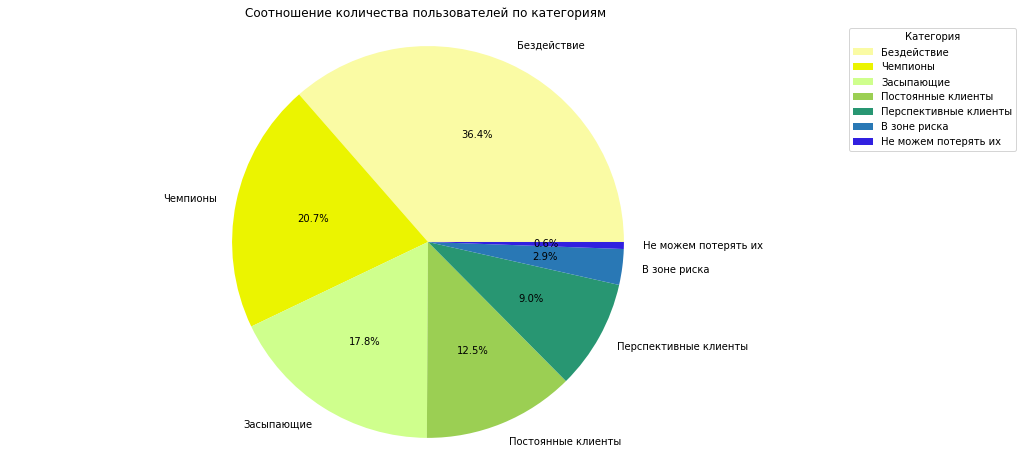

In [82]:
# Создание круговой диаграммы с легендой
plt.figure(figsize=(15, 8))
custom_palette  = ['#FAFBA4', '#EBF400', "#CFFF8D", "#9BCF53", "#289672", "#2978B5", "#3120E0", "#31326F"]
plt.pie(customer_category_count , labels=customer_category_count.index, autopct='%1.1f%%', colors= custom_palette)
plt.title('Соотношение количества пользователей по категориям')
# Задаем равные пропорции, чтобы круг выглядел как круг
plt.axis('equal') 
# Добавим легенду
plt.legend(title='Категория', loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

Исходя из результатов по количеству пользователей в каждой категории RFM: Большую долю клиентов составляют клиенты из группы "Бездействие", это клиенты, которые покупали мало и уже давно. Группа "Чемпионы" следует за категорией "Бездействие" с 505 пользователями, эта группа с высокой активностью и лояльностью. "Засыпающие" и "Постоянные клиенты" имеют сравнительно большое количество пользователей (435 и 306 соответственно).
Наименьшее количество пользователей наблюдается в категории "Не можем потерять их" (14), что может указывать на маленькую, но, возможно, очень ценную группу клиентов, требующую особого внимания и удержания.

### Распределение для показателя Monetary.

Визуально посмотрим как комбинированная оценка rfm распределена для r, f и m.

In [83]:
average_order_value = rfm.groupby('rfm_category')['monetary_value'].median().sort_values(ascending=False)

In [84]:
average_order_value 

rfm_category
Не можем потерять их     2707.0
Постоянные клиенты       1161.0
Чемпионы                 1096.0
В зоне риска              797.5
Бездействие               746.5
Засыпающие                652.0
Перспективные клиенты     637.0
Name: monetary_value, dtype: float64

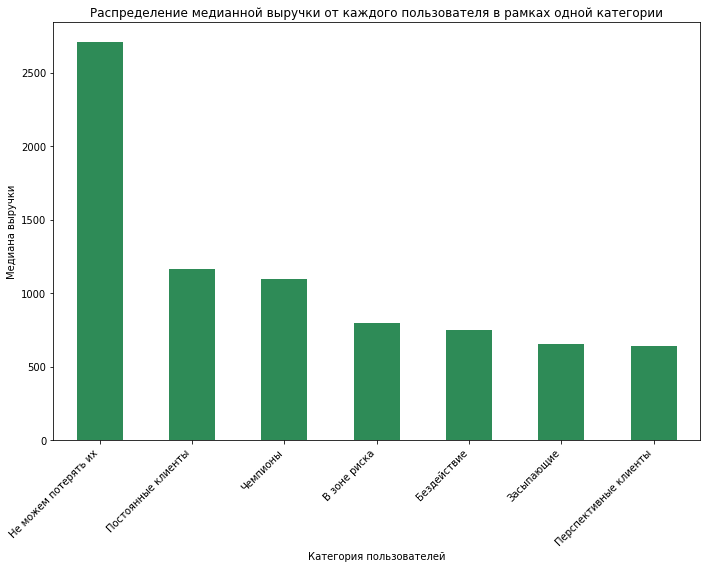

In [85]:
# Построим график
plt.figure(figsize=(10, 8))
average_order_value.plot(kind='bar', color='seagreen')
plt.title('Распределение медианной выручки от каждого пользователя в рамках одной категории')
plt.xlabel('Категория пользователей')
plt.ylabel('Медиана выручки')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Из графика видно, что клиенты из сегмента «Не можем потерять», Постоянные клиенты и «Чемпионы» принесли большую сумму, чем все остальные категории.

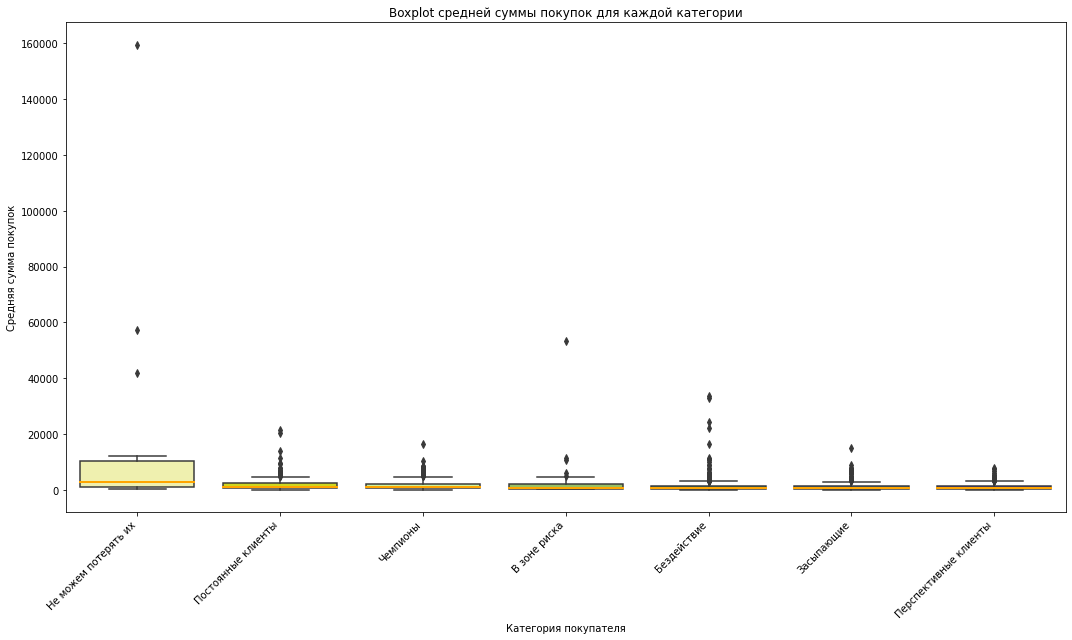

In [86]:
plt.figure(figsize=(15, 9))
custom_palette  = ['#FAFBA4', '#EBF400', "#CFFF8D", "#9BCF53", "#289672", "#2978B5", "#3120E0", "#31326F"]
sns.boxplot(x='rfm_category', y='monetary_value', data=rfm, order=average_order_value.index,
            palette=custom_palette, medianprops={'color': 'orange', 'linewidth': 2})
plt.title('Boxplot средней суммы покупок для каждой категории')
plt.xlabel('Категория покупателя')
plt.ylabel('Средняя сумма покупок')
plt.xticks(rotation=45, ha='right')
# Выведем график на экран
plt.tight_layout()
plt.show()

In [87]:
#попробуем убрать данные больше 6000 что бы четче видель график
selected_rfm = rfm[rfm['monetary_value']<6000]

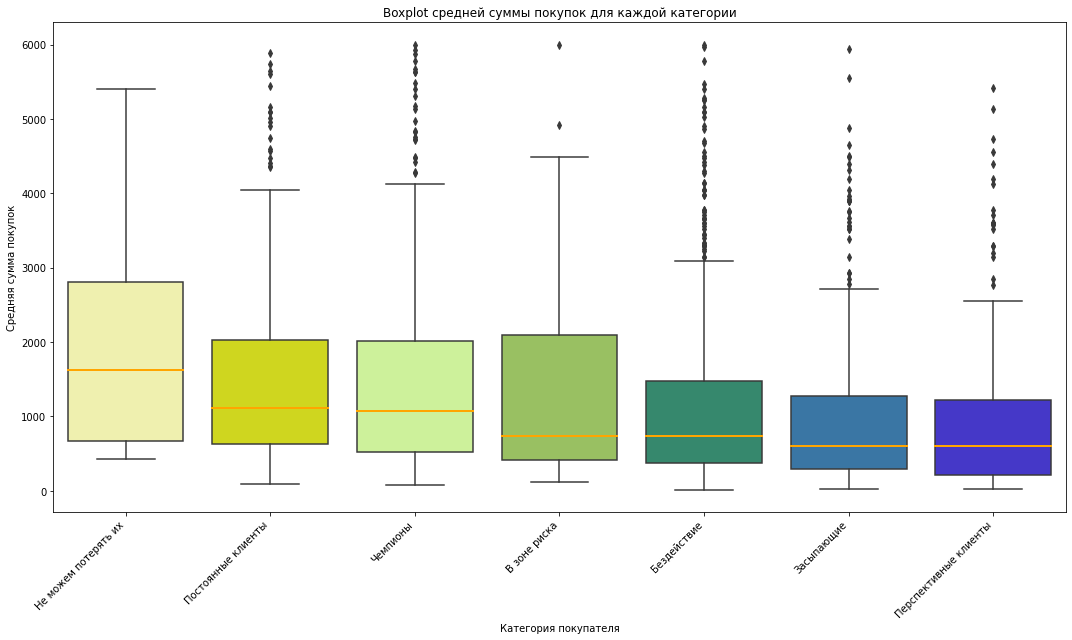

In [88]:
plt.figure(figsize=(15, 9))
custom_palette  = ['#FAFBA4', '#EBF400', "#CFFF8D", "#9BCF53", "#289672", "#2978B5", "#3120E0", "#31326F"]
sns.boxplot(x='rfm_category', y='monetary_value', data=selected_rfm, order=average_order_value.index,
            palette=custom_palette, medianprops={'color': 'orange', 'linewidth': 2})
plt.title('Boxplot средней суммы покупок для каждой категории')
plt.xlabel('Категория покупателя')
plt.ylabel('Средняя сумма покупок')
plt.xticks(rotation=45, ha='right')
# Выведем график на экран
plt.tight_layout()
plt.show()

In [89]:
selected_rfm.groupby('rfm_category')['monetary_value'].describe()

,count,mean,std,min,25%,50%,75%,max
rfm_category,,,,,,,,
Бездействие,873.0,1087.680412,1079.175457,15.0,374.00,734.000000,1473.000,5998.0
В зоне риска,69.0,1376.420290,1321.025876,118.0,418.00,741.000000,2096.000,5998.0
Засыпающие,424.0,1003.183962,1035.658728,22.0,295.75,600.000000,1272.000,5939.0
Не можем потерять их,10.0,2029.800000,1628.455151,434.0,665.00,1619.500000,2805.000,5398.0
Перспективные клиенты,217.0,1005.239631,1117.216974,22.0,220.00,599.000000,1228.000,5420.0
Постоянные клиенты,293.0,1540.732935,1276.356787,95.0,625.50,1108.000000,2023.000,5891.0
Чемпионы,486.0,1486.927298,1299.158537,84.0,525.75,1069.583333,2020.375,5991.0


Из представленных результатов видно, что средняя сумма всех покупок среди клиентов различается в зависимости от категории клиентов по RFM анализу. Например, средняя выручка у категории "Не можем потерять их", "Чемпионы" и "Постоянные клиенты" значительно выше по сравнению с другими категориями. Это может указывать на то, что эти группы клиентов более склонны тратить больше средств на покупки. С другой стороны, средняя выручка у категории "Засыпающие"  ниже, что может свидетельствовать о том, что эти клиенты начинают терять интерес к продукту или услуге.

### Распределение для показателя Frequency.

In [90]:
average_frequency = rfm.groupby('rfm_category')['frequency'].mean().sort_values(ascending=False)

In [91]:
average_frequency

rfm_category
Не можем потерять их     14.428571
Постоянные клиенты        2.104575
В зоне риска              2.000000
Чемпионы                  2.000000
Бездействие               1.000000
Засыпающие                1.000000
Перспективные клиенты     1.000000
Name: frequency, dtype: float64

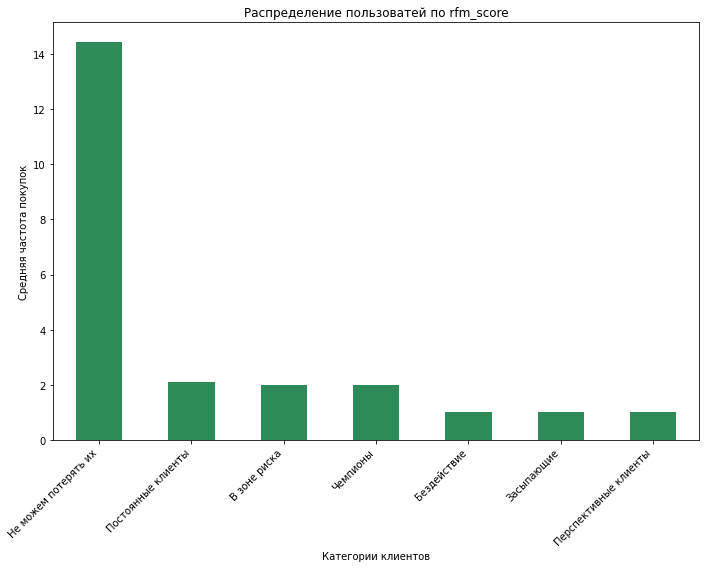

In [92]:
# Построим график
plt.figure(figsize=(10, 8))
average_frequency.plot(kind='bar', color='seagreen')
plt.title('Распределение пользоватей по rfm_score')
plt.xlabel('Категории клиентов')
plt.ylabel('Средняя частота покупок')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Из графика видно, что клиенты из сегмента «Не можем потерять», «В зоне риска», «Чемпионы» и «Постоянные клиенты» имеют самый высокий показатель Frequency.

### Распределение для показателя Recency

In [93]:
average_recency = rfm.groupby('rfm_category')['recency'].mean().sort_values(ascending=False)

In [94]:
average_recency

rfm_category
Бездействие              378.173034
В зоне риска             349.527778
Не можем потерять их     347.642857
Засыпающие               208.811494
Перспективные клиенты    115.452489
Постоянные клиенты       102.326797
Чемпионы                  29.667327
Name: recency, dtype: float64

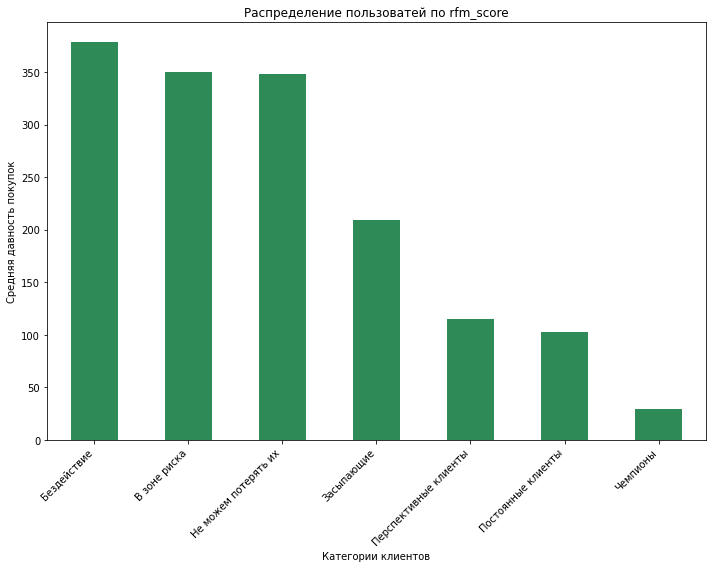

In [95]:
# Построим график
plt.figure(figsize=(10, 8))
average_recency.plot(kind='bar', color='seagreen')
plt.title('Распределение пользоватей по rfm_score')
plt.xlabel('Категории клиентов')
plt.ylabel('Средняя давность покупок')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Из графика видно, что клиенты из сегмента «В зоне бездействия», «Не можем потерять» имеют высокий показатель Recency. Эти клиенты давно совершали покупки и необходимо применять меры для пробуждения интереса, может быть заинтересовать акциями или скидками. 

### Распределение по категориям товара

In [96]:
data['customer_id'] = data['customer_id'].astype(str)
merged_data = data.merge(rfm, on='customer_id', how='left')

In [97]:
merged_data.head()

,date,customer_id,order_id,product,quantity,price,weekday,month,hour,year,...,category,recency,frequency,monetary_value,r,f,m,rfm_segment,rfm_score,rfm_category
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142.0,1,10,0,2018,...,Цветы и рассада,488,1,1037.0,1,1,3,113,5,Бездействие
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке кофе арабика, d12,...",1,194.0,1,10,0,2018,...,Цветы и рассада,488,1,1037.0,1,1,3,113,5,Бездействие
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,радермахера d-12 см h-20 см,1,112.0,1,10,0,2018,...,Цветы и рассада,488,1,1037.0,1,1,3,113,5,Бездействие
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,хризолидокарпус лутесценс d-9 см,1,179.0,1,10,0,2018,...,Цветы и рассада,488,1,1037.0,1,1,3,113,5,Бездействие
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,циперус зумула d-12 см h-25 см,1,112.0,1,10,0,2018,...,Цветы и рассада,488,1,1037.0,1,1,3,113,5,Бездействие


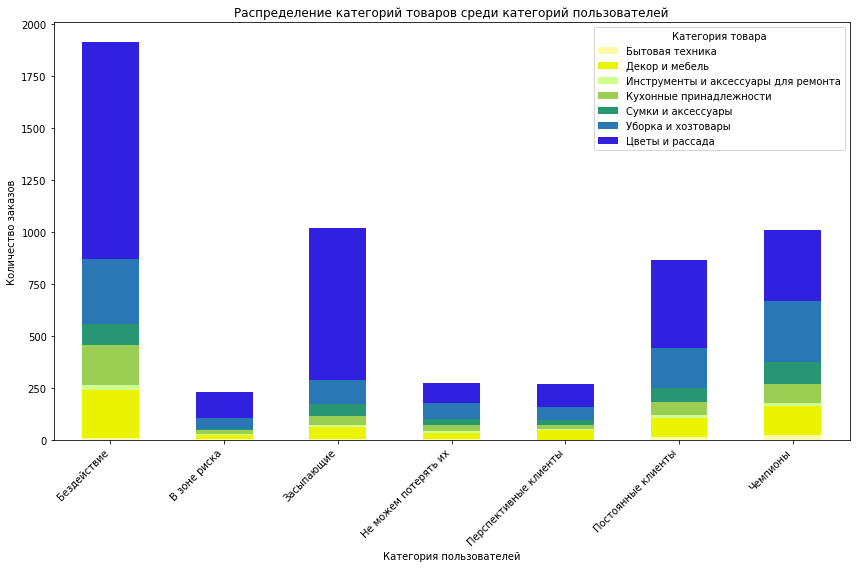

In [98]:
# Сгруппируем данные по категориям товаров и категориям пользователей, затем посчитаем количество заказов
product_category_customer = merged_data.groupby([ 'rfm_category','category']).size().unstack(fill_value=0)
# Отсортируем столбцы в порядке возрастания
custom_palette  = ['#FAFBA4', '#EBF400', "#CFFF8D", "#9BCF53", "#289672", "#2978B5", "#3120E0", "#31326F"]
# Построим график
plt.figure(figsize=(12, 8))
# Построим столбчатую диаграмму
product_category_customer.plot(kind='bar', stacked=True, ax=plt.gca(), color=custom_palette)
# Добавим заголовок и подписи осей
plt.title('Распределение категорий товаров среди категорий пользователей')
plt.xlabel('Категория пользователей')
plt.ylabel('Количество заказов')
plt.xticks(rotation=45, ha='right')
# Выведем график на экран
plt.legend(title='Категория товара')
plt.tight_layout()
plt.show()

Судя по всему, распределение по категориям товаров не особо зависит от категории пользователя, у всех приблизительно одинаковое распределение.

### Средний чек заказа для каждой категории пользователя

In [99]:
# Группировка данных по категории пользователя и идентификатору заказа,
# расчет общей стоимости каждого заказа
orders_by_category = merged_data.groupby(['rfm_category', 'order_id'])['cost'].sum().reset_index()

In [100]:
orders_by_category2 = orders_by_category.groupby('rfm_category')['cost'].agg('median').sort_values(ascending=False)

In [101]:
orders_by_category2

rfm_category
Не можем потерять их     803.5
Бездействие              749.0
Засыпающие               674.0
Перспективные клиенты    599.0
Постоянные клиенты       476.0
В зоне риска             470.0
Чемпионы                 389.0
Name: cost, dtype: float64

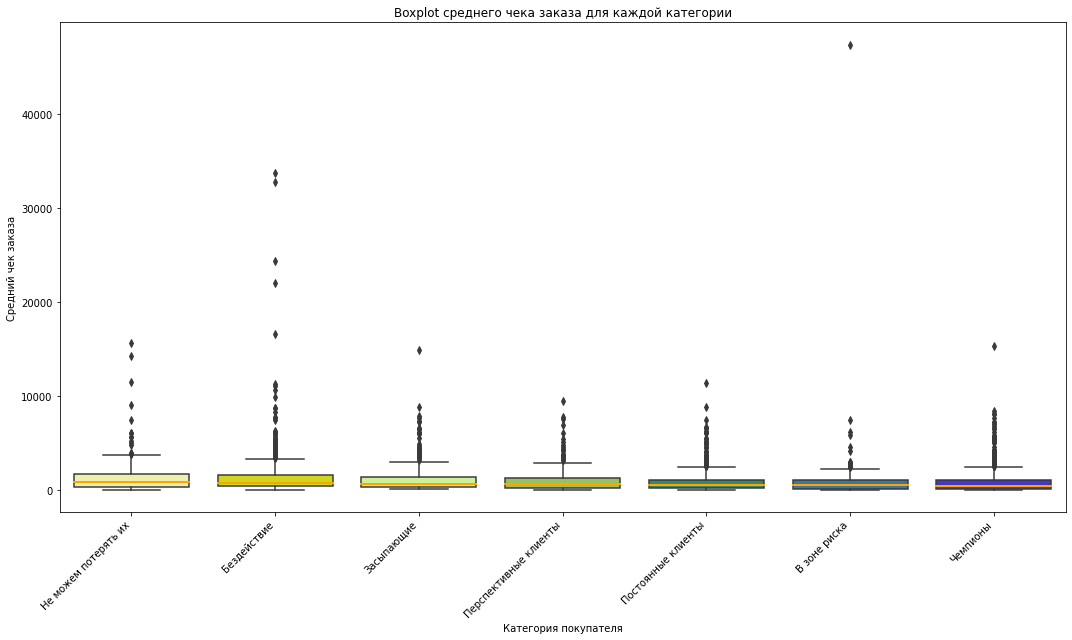

In [102]:
plt.figure(figsize=(15, 9))
custom_palette  = ['#FAFBA4', '#EBF400', "#CFFF8D", "#9BCF53", "#289672", "#2978B5", "#3120E0", "#31326F"]
sns.boxplot(x='rfm_category', y='cost', data=orders_by_category, order = orders_by_category2.index,
            palette=custom_palette, medianprops={'color': 'orange', 'linewidth': 2})
plt.title('Boxplot среднего чека заказа для каждой категории')
plt.xlabel('Категория покупателя')
plt.ylabel('Средний чек заказа')
plt.xticks(rotation=45, ha='right')
# Выведем график на экран
plt.tight_layout()
plt.show()

In [103]:
sel_data = orders_by_category[orders_by_category['cost'] <10000]

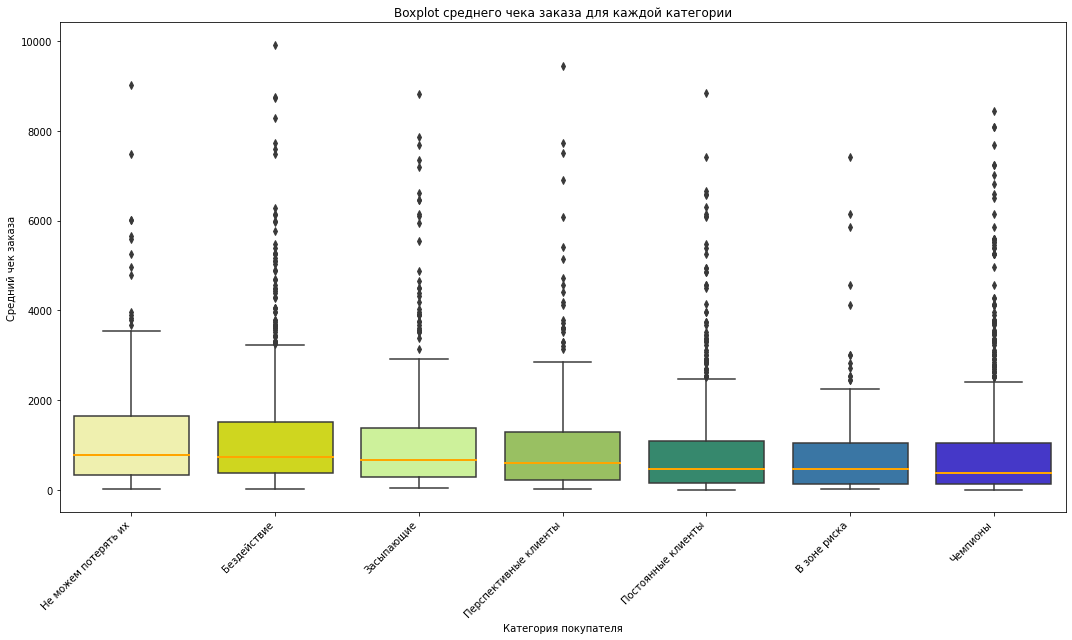

In [104]:
plt.figure(figsize=(15, 9))
custom_palette  = ['#FAFBA4', '#EBF400', "#CFFF8D", "#9BCF53", "#289672", "#2978B5", "#3120E0", "#31326F"]
sns.boxplot(x='rfm_category', y='cost', data=sel_data, order = orders_by_category2.index,
            palette=custom_palette, medianprops={'color': 'orange', 'linewidth': 2})
plt.title('Boxplot среднего чека заказа для каждой категории')
plt.xlabel('Категория покупателя')
plt.ylabel('Средний чек заказа')
plt.xticks(rotation=45, ha='right')
# Выведем график на экран
plt.tight_layout()
plt.show()

In [105]:
orders_by_category.groupby('rfm_category')['cost'].describe()

,count,mean,std,min,25%,50%,75%,max
rfm_category,,,,,,,,
Бездействие,881.0,1340.030647,2376.016785,15.0,374.00,749.0,1572.00,33680.0
В зоне риска,144.0,1183.861111,4048.875155,29.0,138.50,470.0,1063.75,47385.0
Засыпающие,432.0,1182.710648,1526.962302,38.0,299.00,674.0,1391.75,14917.0
Не можем потерять их,202.0,1440.985149,2075.822670,22.0,352.50,803.5,1724.00,15680.0
Перспективные клиенты,216.0,1140.421296,1495.892818,22.0,219.25,599.0,1293.50,9440.0
Постоянные клиенты,642.0,912.309579,1260.344926,11.0,156.25,476.0,1087.00,11400.0
Чемпионы,1005.0,874.104146,1334.563619,9.0,127.00,389.0,1049.00,15358.0


Из анализа среднего чека для различных категорий пользователей видно, что существует значительное разнообразие в размере покупок. Некоторые группы, такие как "Бездействие" и "Не можем потерять их", проявляют тенденцию к совершению более крупных покупок, в то время как другие, например, "Постоянные клиенты", склонны к покупкам меньшего размера.

### Общее и среднее количество заказов для каждой категории пользователя

In [106]:
# Сгруппируем данные по категориям пользователей и рассчитаем количество заказов для каждой группы
grouped_data = merged_data.groupby('rfm_category')['order_id'].agg('nunique').sort_values(ascending=False).reset_index()

In [107]:
grouped_data

,rfm_category,order_id
0,Чемпионы,1005
1,Бездействие,881
2,Постоянные клиенты,642
3,Засыпающие,432
4,Перспективные клиенты,216
5,Не можем потерять их,202
6,В зоне риска,144


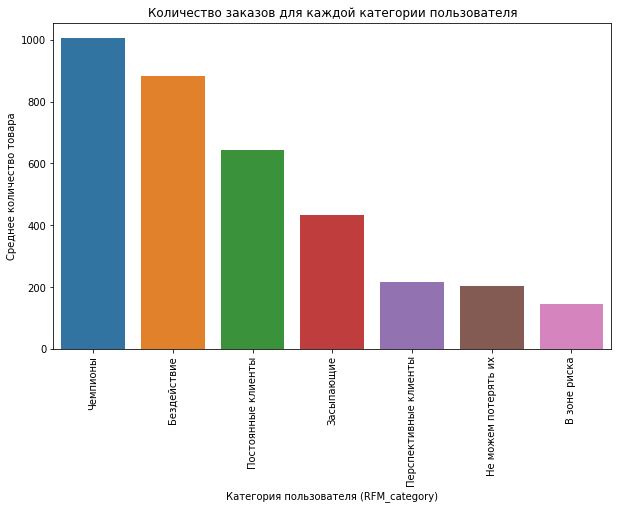

In [108]:
# Визуализация количества заказов для каждой категории пользователя
plt.figure(figsize=(10, 6))
sns.barplot(x='rfm_category', y='order_id', data=grouped_data)
plt.title('Количество заказов для каждой категории пользователя')
plt.xlabel('Категория пользователя (RFM_category)')
plt.ylabel('Среднее количество товара')
plt.xticks(rotation=90)
plt.show()

Исходя из предоставленных данных об общем количестве заказов в каждой категории RFM:
Категория "Чемпионы" имеет наибольшее общее количество заказов, что указывает на высокий уровень активности и лояльности этой группы клиентов. Категория "Постоянные клиенты" также имеет значительное количество заказов, что свидетельствует о стабильной активности этой группы клиентов.
Группы "Засыпающие" и "Перспективные клиенты" имеют менее значительное количество заказов по сравнению с предыдущими категориями. Категории "Не можем потерять их" и "В зоне риска" имеют наименьшее общее количество заказов, что может свидетельствовать о нестабильной активности.

In [109]:
mean_orders_per_user_by_category = merged_data.groupby(['rfm_category', 'customer_id'])['order_id'].nunique().groupby('rfm_category').mean().sort_values(ascending=False).reset_index()

In [110]:
mean_orders_per_user_by_category

,rfm_category,order_id
0,Не можем потерять их,14.428571
1,Постоянные клиенты,2.104575
2,В зоне риска,2.000000
3,Чемпионы,2.000000
4,Бездействие,1.000000
5,Засыпающие,1.000000
6,Перспективные клиенты,1.000000


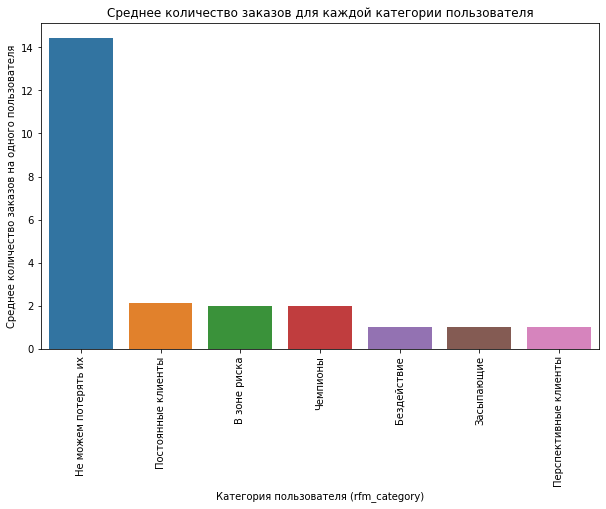

In [111]:
# Визуализация среднего количества заказов одного пользователя для каждой категории пользователя
plt.figure(figsize=(10, 6))
sns.barplot(x='rfm_category', y='order_id', data=mean_orders_per_user_by_category)
plt.title('Среднее количество заказов для каждой категории пользователя')
plt.xlabel('Категория пользователя (rfm_category)')
plt.ylabel('Среднее количество заказов на одного пользователя')
plt.xticks(rotation=90)
plt.show()

Клиенты в категории "Не можем потерять их" совершают в среднем более 14 заказов, что значительно превышает среднее количество заказов у клиентов в других категориях. Это может указывать на высокую лояльность и активность данной группы клиентов.
Категории "Постоянные клиенты" и "Чемпионы" также имеют сравнительно высокое среднее количество заказов на пользователя (более 2 заказов). Это может свидетельствовать о стабильной активности и верности клиентов из этих категорий.
В то время как большинство категорий имеют среднее количество заказов в районе 1-2.

### Вывод

Исходя из анализа сегментации пользователей по RFM-анализу, можно сделать следующие выводы:

Среди всех категорий клиентов наибольшую долю составляют клиенты из группы "Бездействие", которые покупали мало и уже давно. Группа "Чемпионы" следует за ними с высокой активностью и лояльностью.
"Засыпающие" и "Постоянные клиенты" имеют сравнительно большое количество пользователей, что указывает на стабильную активность в этих группах.
Наименьшее количество пользователей наблюдается в категории "Не можем потерять их", что может указывать на маленькую, но, возможно, очень ценную группу клиентов, требующую особого внимания и удержания.
Анализ среднего чека показал значительное разнообразие в размере покупок в зависимости от категории пользователей. Некоторые группы, такие как "Бездействие" и "Не можем потерять их", проявляют тенденцию к совершению более крупных покупок, в то время как другие, например, "Постоянные клиенты", склонны к покупкам меньшего размера.
Общее количество заказов для каждой категории пользователя также различается. Категория "Чемпионы" имеет наибольшее общее количество заказов, что указывает на высокий уровень активности и лояльности этой группы клиентов. Категория "Постоянные клиенты" также имеет значительное количество заказов, свидетельствуя о стабильной активности этой группы клиентов. Наименьшее общее количество заказов наблюдается в категориях "Не можем потерять их" и "В зоне риска".
Среднее количество заказов на пользователя в категории "Не можем потерять их" значительно превышает другие категории, что может свидетельствовать о высокой лояльности и активности данной группы клиентов. Категории "Постоянные клиенты" и "Чемпионы" также имеют сравнительно высокое среднее количество заказов на пользователя, указывая на их стабильную активность и верность.
Таким образом, анализ RFM-сегментации позволяет выявить различные характеристики поведения клиентов и эффективно настраивать маркетинговые стратегии для каждой категории пользователей.

## Формирование и проверка гипотез

На основе данных категорий пользователей (rfm_category) можно сформулировать и проверить различные гипотезы.

### Формирование и проверка первой гипотезы

Гипотеза о различии среднего чека между категориями пользователей: 
- Нулевая гипотеза 𝐻o: Средний чек не различается между категориями пользователей. 
- Альтернативная гипотеза H1: Средний чек различается между категориями пользователей. 

Для начала попробует сравнить группы "Чемпионы" и "Постоянные клиенты", были выбраны исходя из выводов, сделанных в анализе. Эти группы имеют схожий уровень активности и лояльности, что делает интересным сравнение их средних чеков заказа. 

In [112]:
# Создадим выборки для сравнения (категории "Чемпионы" и "Постоянные клиенты")
category_champions = orders_by_category[orders_by_category['rfm_category'] == 'Чемпионы']['cost']
category_regulars = orders_by_category[orders_by_category['rfm_category'] == 'Постоянные клиенты']['cost']

# Примененим тест Манна-Уитни
statistic, p_value = mannwhitneyu(category_champions, category_regulars)

# Выведем результаты
print("Статистика теста:", statistic)
print("p-значение:", p_value)

# Проверим статистическую значимость
alpha = 0.05
if p_value < alpha:
    print("Разница статистически значима: отвергаем нулевую гипотезу")
else:
    print("Нет статистической значимости: не отвергаем нулевую гипотезу")

Статистика теста: 294352.5
p-значение: 0.0026867497352356293
Разница статистически значима: отвергаем нулевую гипотезу


Учитывая, что p-значение (0.0027) меньше выбранного уровня значимости (обычно 0.05), мы отвергаем нулевую гипотезу. Это означает, что существует статистически значимое различие в среднем чеке между категориями "Чемпионы" и "Постоянные клиенты".

### Формирование и проверка второй гипотезы¶

 Гипотеза о различии структуры покупок (например, предпочтения товарных категорий) между категориями пользователей: 
 - Нулевая гипотеза H0: Структура покупок (распределение покупок по различным категориям товаров) не различается между категориями пользователей. 
 - Альтернативная гипотеза H1: Структура покупок различается между категориями пользователей. 

In [113]:
# Группируем данные
grouped_data = merged_data.groupby(['rfm_category', 'category'])['order_id'].count().reset_index()

# Проведем анализ ANOVA
anova_result = f_oneway(*[grouped_data[grouped_data['rfm_category'] == category]['order_id'] for category in grouped_data['rfm_category'].unique()])

# Выведем полученные результаты:
print("Результаты ANOVA:")
print("Статистика теста:", anova_result.statistic)
print("p-значение:", anova_result.pvalue)

# Проверим статистическую значимость
alpha = 0.05
if anova_result.pvalue < alpha:
    print("Различие в структуре покупок между категориями пользователей статистически значимо")
else:
    print("Нет статистически значимого различия в структуре покупок между категориями пользователей")

Результаты ANOVA:
Статистика теста: 1.5641711988764029
p-значение: 0.18155293433589786
Нет статистически значимого различия в структуре покупок между категориями пользователей


Результаты анализа ANOVA показывают, что статистика теста равна 1.564, а p-значение составляет 0.182. Поскольку p-значение превышает выбранный уровень значимости 0.05, нет достаточных доказательств для отвержения нулевой гипотезы. Это означает, что нет статистически значимого различия в структуре покупок между категориями пользователей на основе RFM-анализа. То есть, не существует различий в предпочтениях товарных категорий между разными сегментами пользователей.

# Вывод

Анализ данных по распределению заказов по месяцам, дням недели и категориям товаров позволил выявить ключевые тенденции. В период с февраля по апрель наблюдается наибольшая активность покупателей, возможно, связанная с сезонными факторами или проведением маркетинговых акций. Суббота выделяется наименьшим количеством заказов, в то время как вторник - днем с наибольшей активностью. Цветы и рассада являются наиболее популярной категорией товаров, а сумки и аксессуары, хотя и имеют меньшее количество заказов, приносят значительную выручку.
Сегментация пользователей на основе RFM-анализа выявила разнообразные группы, от "Чемпионов" - активных и лояльных клиентов, до "Бездействия" - тех, кто совершает мало покупок уже давно. Анализ среднего чека подтвердил различия в покупательском поведении между категориями пользователей, особенно между "Чемпионами" и "Постоянными клиентами".
Несмотря на это, результаты анализа структуры покупок с использованием ANOVA не показали статистически значимых различий между категориями пользователей. Это означает, что предпочтения товарных категорий остаются схожими независимо от сегмента пользователя. Такие выводы могут быть использованы для оптимизации маркетинговых стратегий и управления ассортиментом товаров в интернет-магазине.

# Рекомендации для отдела маркетинга

Каждой категории клиентов можно дать персонализированные рекомендации для эффективного взаимодействия и удержания:

- **Чемпионы**: Вознаграждайте их за лояльность, предлагая эксклюзивные предложения. Активно вовлекайте их в новые продукты и инициативы, так как они могут стать вашими амбассадорами бренда.
- **Постоянные клиенты**: Продолжайте стимулировать их покупки, предлагая продукты более высокого уровня или привлекательные акции. Приглашайте их оставлять отзывы и участвовать в программе лояльности.
- **Потенциальные лоялисты**: Предложите им преимущества участия в программе лояльности и рекомендуйте дополнительные продукты, которые могут заинтересовать их.
- **Недавние клиенты**: Поддерживайте контакт с ними через персонализированные рассылки и привлекательные предложения, чтобы убедить их совершать более частые покупки.
- **Многообещающие**: Увеличивайте узнаваемость бренда и предлагайте пробные версии или скидки, чтобы закрепить их заинтересованность.
- **Клиенты, нуждающиеся во внимании**: Активно взаимодействуйте с ними, предлагая ограниченные по времени предложения и персонализированные подборки товаров.
- **Засыпающие**: Поддерживайте их интерес, предлагая ценные ресурсы и информацию о новинках и распродажах.
- **В зоне риска потери**: Персонализируйте свои предложения, чтобы вернуть их обратно, предлагая скидки и дополнительные преимущества для лояльных клиентов.
- **Не можем их потерять**: Предложите им уникальные преимущества, такие как VIP-статус или эксклюзивные предложения, чтобы вернуть их к вам.
- **Уходящие в спящий режим**: Сделайте им специальное предложение или скидку, чтобы привлечь их внимание и вернуть обратно к активным покупкам.
- **Потерянные**: В зависимости от их потенциальной ценности, решите, стоит ли восстанавливать с ними контакт или лучше сосредоточиться на других клиентских сегментах.

Материалы Презентация: https://drive.google.com/file/d/1bqDKUMRistM8aOVW0ALu9ioVx4G1dfAW/view?usp=sharing